# **RaquelRocha**
### **Case Técnico - Ioasys**

---

# **0.0 Imports**

In [1]:
import math
import inflection
import pickle
import warnings
import random

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.gridspec as gridspec
import plotly.express      as px

#from scipy      import stats       as ss

from IPython.core.display           import HTML
from IPython.display                import Image
from scipy.stats                    import chi2_contingency,shapiro

from sklearn                        import preprocessing      as pp

from matplotlib                     import pyplot             as plt
from sklearn.model_selection        import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing          import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn                        import model_selection    as ms
from sklearn                        import linear_model       as lm
from sklearn                        import ensemble           as en


from boruta                         import BorutaPy
from sklearn.ensemble               import RandomForestRegressor
from sklearn.neighbors              import KNeighborsRegressor


from sklearn.metrics                import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model           import LinearRegression, Lasso

import xgboost             as xgb
from math                           import sqrt

#import datetime


## **0.1 Helper Functions**

In [2]:
#Configuração gerais
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
warnings.filterwarnings("ignore")



#Estatística descritiva - medidas central.
def descriptive_statistics(df1_num):
    
    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T

    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    df_statistics.round(2)

    return df_statistics



#Gráfico de correlação 
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap="Blue").set_title(col);
    
    return plot



#Correlação variáveis categóricas
def cramer_v(x, y):
    # cramer V function to calculate correlation btw categorical variables
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


warnings.filterwarnings ("ignore") 



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/raquelrocha/opt/anaconda3/envs/ioasys/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sqrt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## **0.2 Loading Data**

Essa etapa visa entender como será feito o "loading" dos dados necessários para elaborar as analises:

•load do csv

•entender a granularidade dos dados

•perceber as chaves primárias e estrangeiras para efetivar os "joins"

•verificar se o arquivo final(raw) manteve o número correto de linhas

In [3]:
df_raw_train = pd.read_csv("/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/dados/train.csv",low_memory = False)
df_raw_stores = pd.read_csv("/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/dados/stores.csv",low_memory = False)
df_raw_features = pd.read_csv("/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/dados/features.csv",low_memory = False)


In [4]:
print ("Number of Rows:{}".format(df_raw_train.shape[0]))
print ("Number of Rows:{}".format(df_raw_stores.shape[0]))
print ("Number of Rows:{}".format(df_raw_features.shape[0]))


Number of Rows:421570
Number of Rows:45
Number of Rows:8190


In [5]:
#verificando os nomes das colunas
df_raw_features.sample()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8123,45,2012-04-20,63.13,4.027,9210.9,2667.05,6.25,970.33,2568.22,190.813801,8.567,False


In [6]:
#merge dataframes
df_raw = df_raw_train.merge(df_raw_features,how='inner', on=['Store', 'Date', 'IsHoliday']).merge(df_raw_stores, how='inner', on='Store')


In [7]:
print ("Number of Rows:{}".format(df_raw.shape[0]))


Number of Rows:421570


# **1.0 Data Description**

In [8]:
df1 = df_raw.copy()

In [9]:
df1.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

## **1.1 Rename Columns**

In [10]:
cols_old = df1.columns.tolist()

# função para deixar a lista em minúsculo e em snakecase(_)
snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'dept', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4',
       'mark_down5', 'cpi', 'unemployment', 'type', 'size'],
      dtype='object')

## **1.2 Data Dimensions**

In [12]:
print ("Number of Rows:{}".format(df1.shape[0]))
print ("Number of Cols:{}".format(df1.shape[1]))

Number of Rows:421570
Number of Cols:16


## **1.3 Data Types**

Nesse passo verifico se o tipo dos dados confere com o tipo que apresenta no arquivo.
Identificamos 2 variáveis com o tipo do dado a ser modificado, sendo elas:

"date" e "is_holiday"

In [13]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

In [14]:
df1.head(3)

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


## **1.4 Check NA**

In [15]:
df1.isna().sum()

store                0
dept                 0
date                 0
weekly_sales         0
is_holiday           0
temperature          0
fuel_price           0
mark_down1      270889
mark_down2      310322
mark_down3      284479
mark_down4      286603
mark_down5      270138
cpi                  0
unemployment         0
type                 0
size                 0
dtype: int64

In [16]:
(df1.isna().sum()/len(df1))*100

store            0.000000
dept             0.000000
date             0.000000
weekly_sales     0.000000
is_holiday       0.000000
temperature      0.000000
fuel_price       0.000000
mark_down1      64.257181
mark_down2      73.611025
mark_down3      67.480845
mark_down4      67.984676
mark_down5      64.079038
cpi              0.000000
unemployment     0.000000
type             0.000000
size             0.000000
dtype: float64

## **1.5 Fillout NA**

Verificando a quantidade de dados na/nulos, percebemos uma parte expressiva nas coluna Markdown 1,2,3,4 e 5

Por contar +60% dos dados faltantes, foi decidido colocar o número 0 no local. Esse número irá indicar que não houve inserção de valor.


In [17]:
df1["mark_down4"].unique()

array([    nan, 2406.62,  427.39, ...,  599.32,  437.73,  211.94])

In [18]:
df1.fillna(0, inplace=True)

## **1.6 Change Types**

In [19]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

In [20]:
df1["mark_down4"].unique()

array([   0.  , 2406.62,  427.39, ...,  599.32,  437.73,  211.94])

In [21]:
#date
df1["date"] = pd.to_datetime(df1["date"])
#weekly_sales - organizando os dias da semana (int) pela data
#df1["weekly_sales"] = df1.apply(lambda x: x["date"].week if math.isnan( x["weekly_sales"]) else x["weekly_sales"], axis=1)
#df1["weekly_sales"] = df1["weekly_sales"].astype(int)
#is_holiday - trocar valor boolean por string
df1["is_holiday"] = df1["is_holiday"].replace([False],"Nao")
df1["is_holiday"] = df1["is_holiday"].replace([True],"Sim")



## **1.7 Descriptive Statistical**

In [22]:
df1_num=df1.select_dtypes(include=['int64', 'float64'])
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### **1.7.1 Numerical Attributes**

Observacões relevantes:

•Valores mínimos negativos nas variáveis weekly_sales e markdown, que devem ser analisados e tratados a posteriori,

•Nenhuma das variáveis numéricas possuem distribuição normal,

•As variáveis: "cpi", "fuel_price" e "size" demonstram uma distribuição bimodal(duas modas distintas),

•A variável target possui valores negativos, os quais serão tratados em passo posterior.

In [23]:
descriptive_statistics(df1_num)

,min,max,range,mean,median,std,skew,kurtosis,shapiro
store,1.0,45.0,44.0,22.200546,22.0,12.785282,0.077763,-1.146503,not normal
dept,1.0,99.0,98.0,44.260317,37.0,30.492018,0.358223,-1.215571,not normal
weekly_sales,-4988.94,693099.36,698088.3,15981.258123,7612.03,22711.156583,3.262008,21.49129,not normal
temperature,-2.06,100.14,102.2,60.090059,62.09,18.447909,-0.321404,-0.635922,not normal
fuel_price,2.472,4.468,1.996,3.361027,3.452,0.458514,-0.104901,-1.185405,not normal
mark_down1,0.0,88646.76,88646.76,2590.074819,0.0,6052.378756,4.731304,34.917236,not normal
mark_down2,-265.76,104519.54,104785.3,879.974298,0.0,5084.53277,10.645956,145.421293,not normal
mark_down3,-29.1,141630.61,141659.71,468.087665,0.0,5528.866895,14.922341,248.095371,not normal
mark_down4,0.0,67474.85,67474.85,1083.132268,0.0,3894.525326,8.077666,86.242339,not normal
mark_down5,0.0,108519.28,108519.28,1662.772385,0.0,4207.62433,9.964519,183.408065,not normal


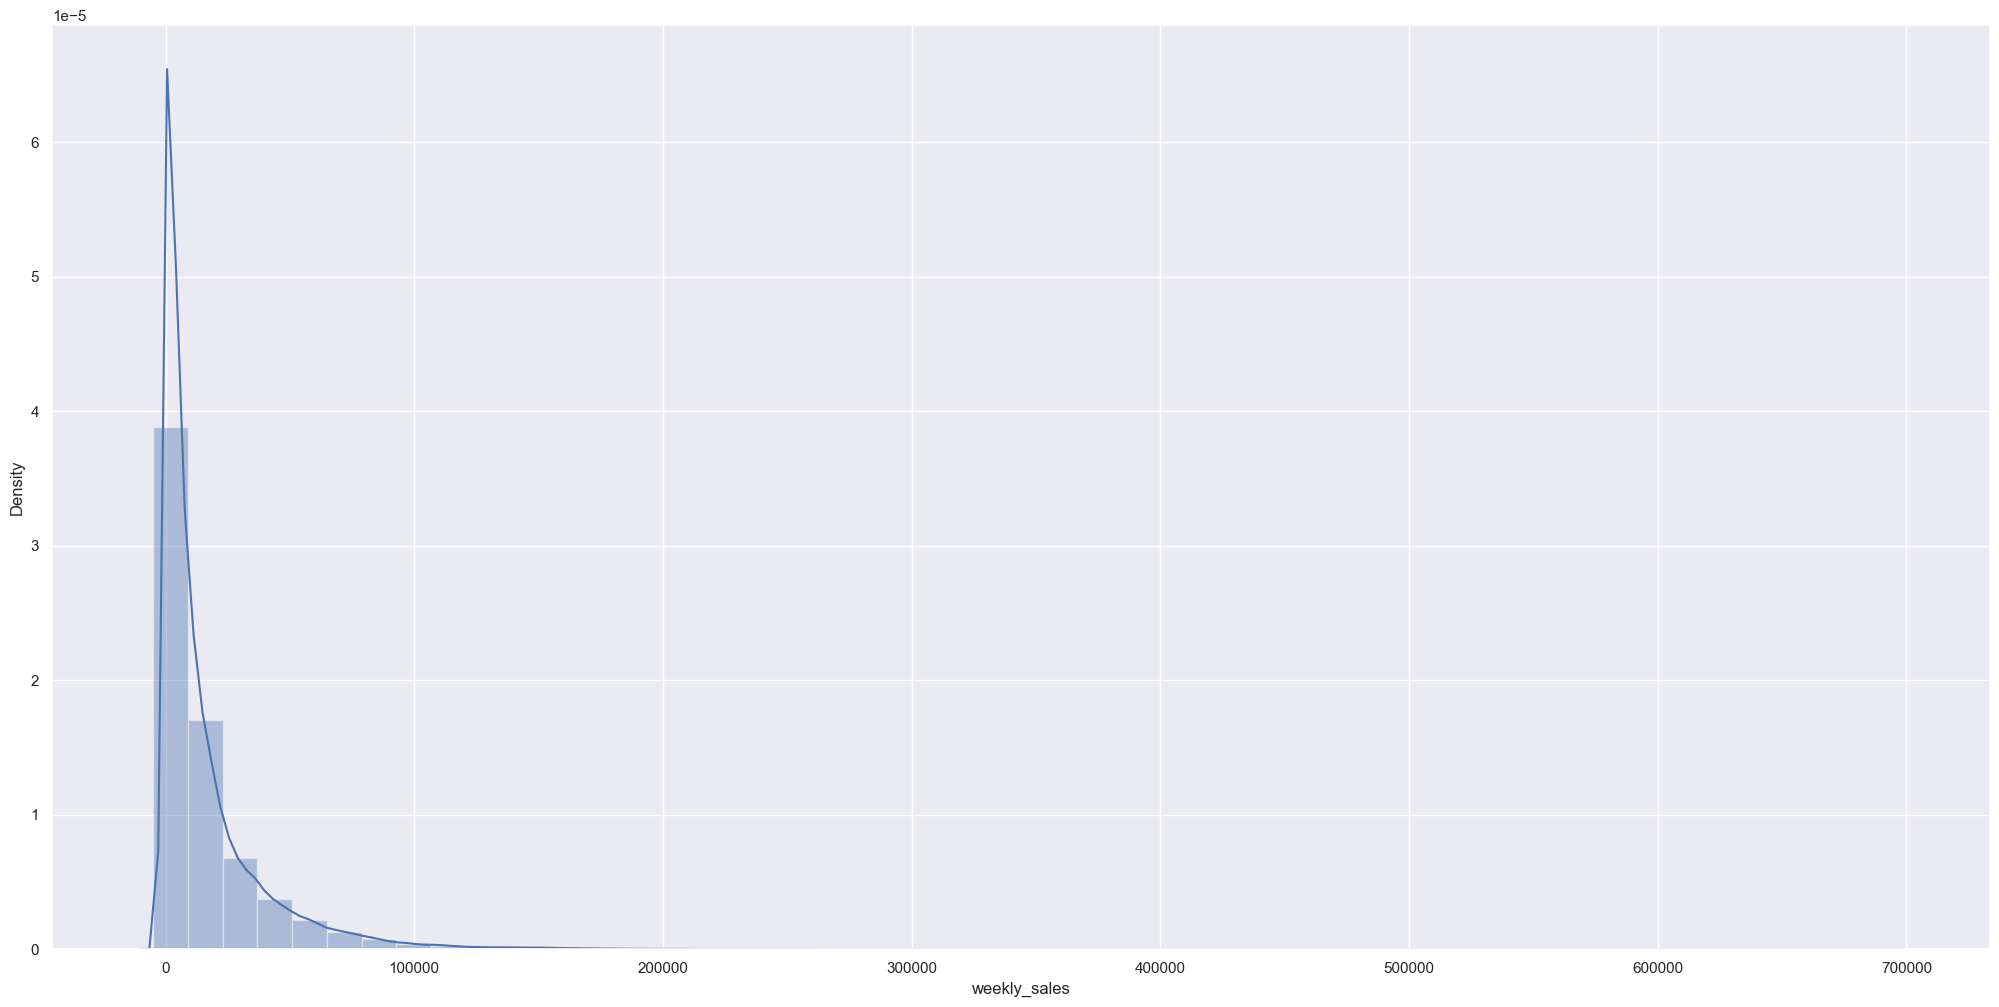

In [24]:
#Distribuição das vendas(sales)
sns.distplot(df1["weekly_sales"]);


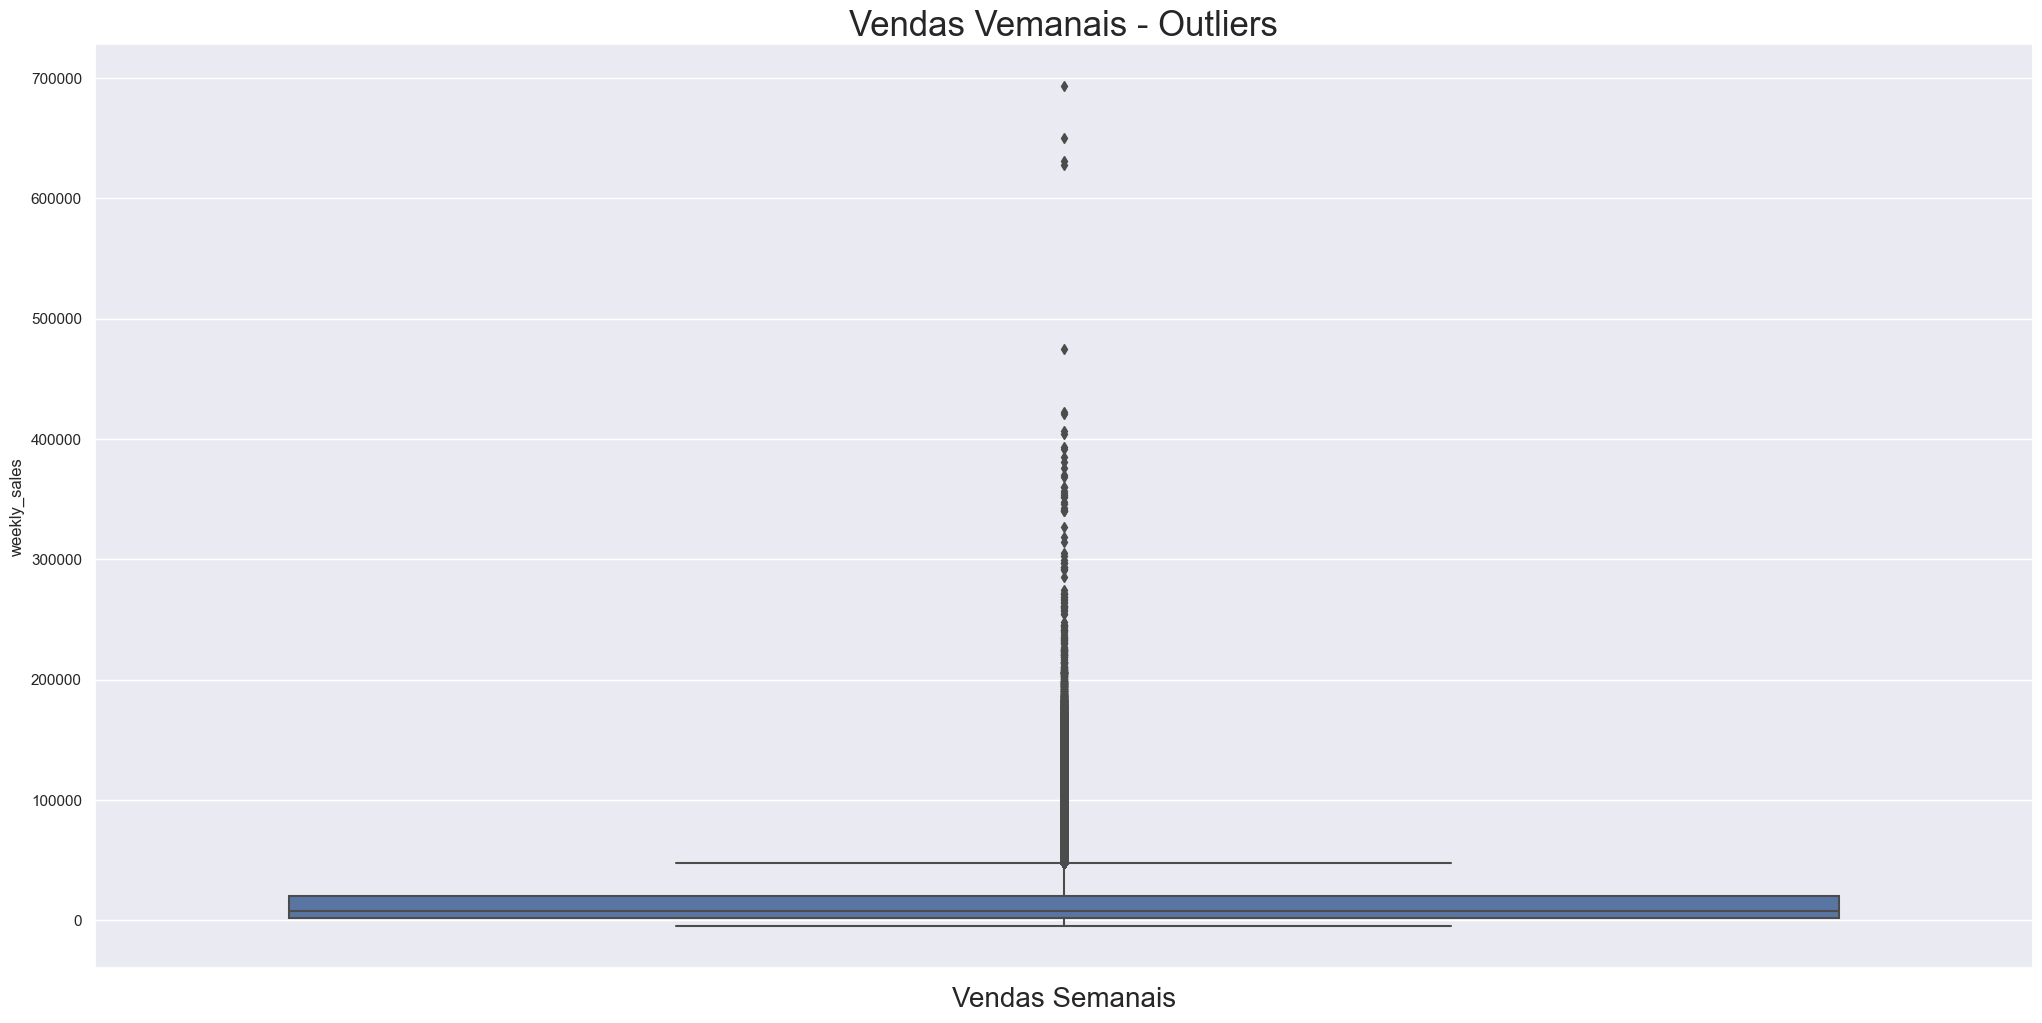

In [25]:
sns.boxplot(y="weekly_sales", data=df1).set_title("Vendas Vemanais - Outliers", fontsize=25)
plt.xlabel("Vendas Semanais", size=20)
plt.xticks(size=20);


### **1.7.2 Categorical Attributes**

In [26]:
df1_cat.apply(lambda x: x.unique().shape[0])


is_holiday    2
type          3
dtype: int64

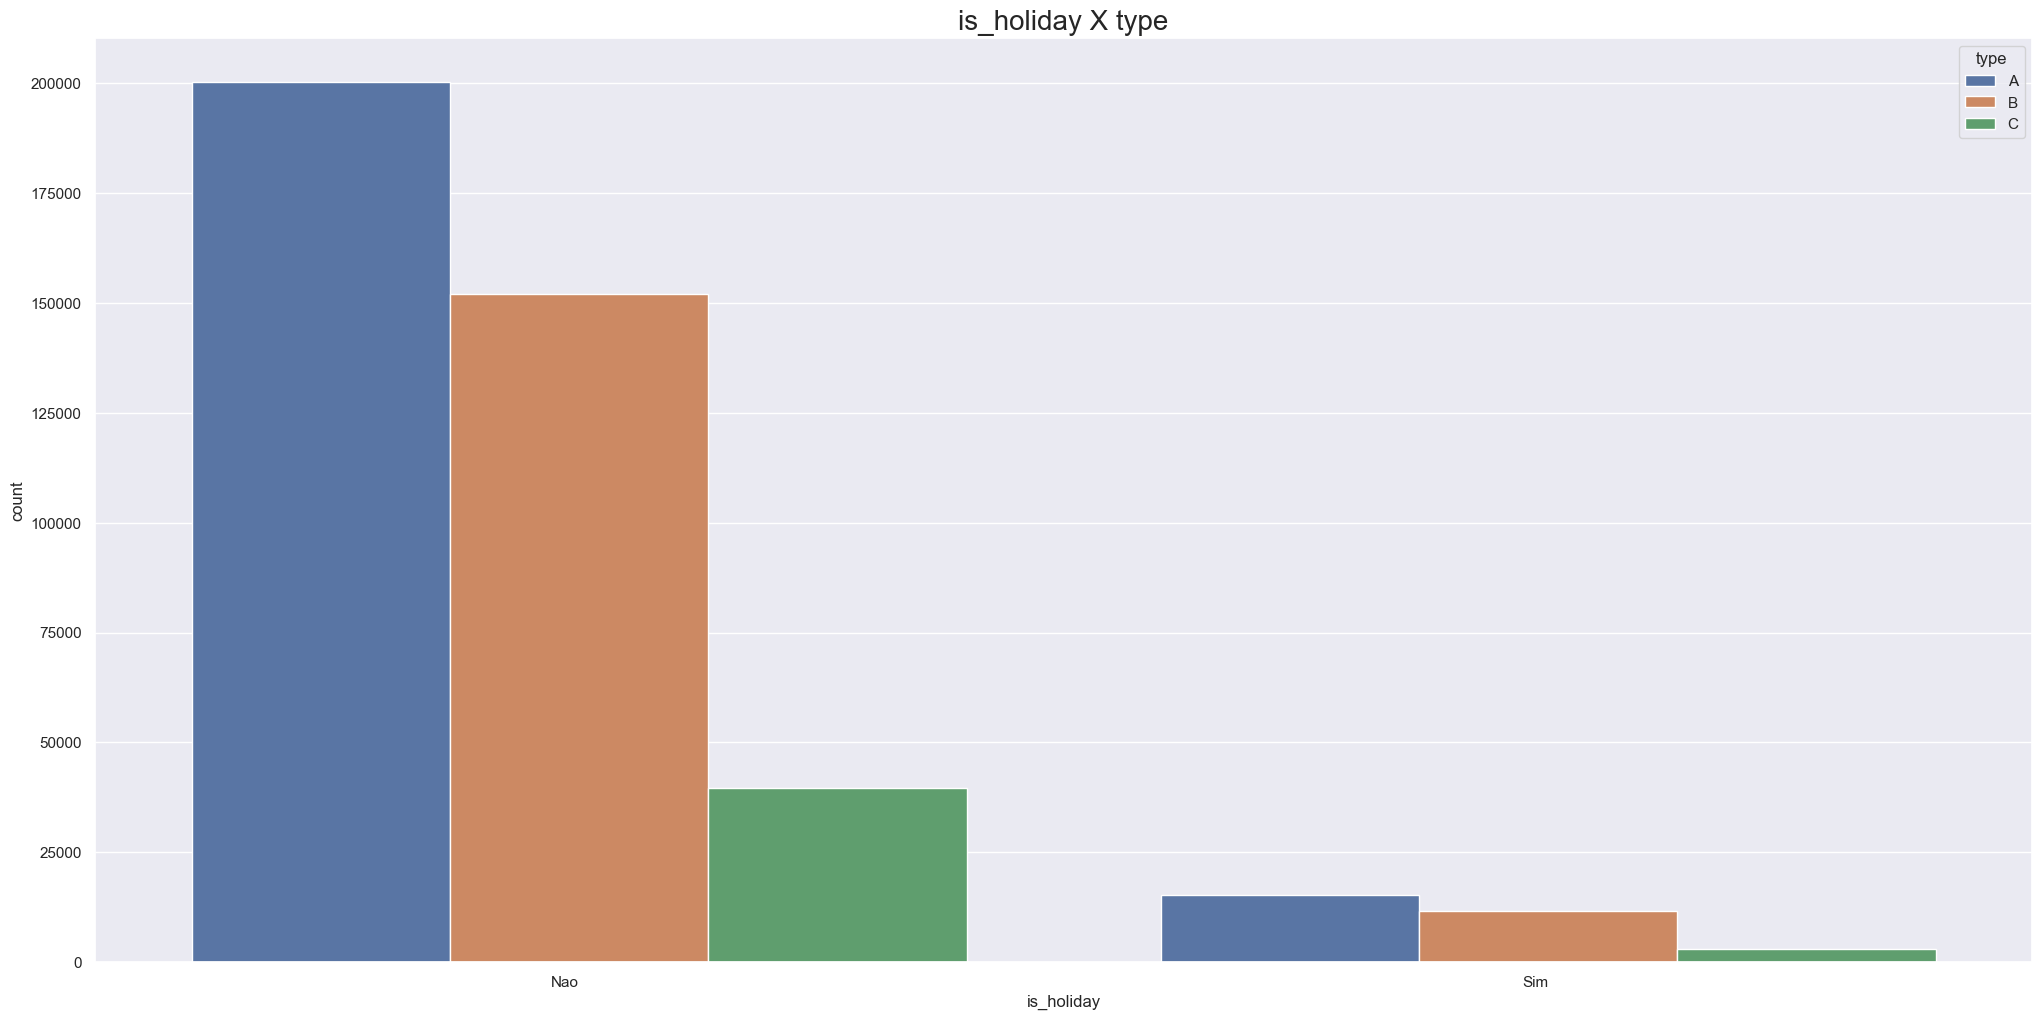

In [27]:
ai=sns.countplot(x='is_holiday', hue='type', data=df1)
ai.set_xticklabels(ai.get_xticklabels(), horizontalalignment='right')
ai.set_title('is_holiday X type', fontsize=20);


## **2.1 Hypotesis**

In [28]:
df2 = df1.copy()

In [29]:
df2.sample()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
254781,26,31,2012-04-13,1103.87,Nao,36.9,4.025,3766.78,2941.14,24.34,1103.96,2536.7,137.868,7.489,A,152513


### **2.1.1 Hypotheses List**

H1- Lojas maiores vendem mais.

H2- Lojas com custo de combustível mais alto vendem menos. 

H3- Dias mais quentes tende a vender menos. 

H4- Meses com variação do índice de preços ao consumidor maiores deveriam vender menos.

H5- Ano em que a taxa de desemprego foi maior deveria vender menos.

H6- Lojas em dias de promoção vendem mais.

H7- Lojas abertas durante o período de feriados importantes(super bowl, dia do trabalhador, natal, ação de graças...) deveriam vender mais.

H8- Setor de lojas tipo A tem melhores resultados com vendas.

## **2.2 Feature Engineering**

In [30]:
#Variáveis a ser derivadas da variável original Date
# year 
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

#Transformando de Fahrenheit para Celsius
df2["temperature"] = (df2["temperature"] - 32) * 5/9



In [31]:
df2.head()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size,year,month,day,week_of_year
0,1,1,2010-02-05,24924.50,Nao,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,5
1,1,2,2010-02-05,50605.27,Nao,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,5
2,1,3,2010-02-05,13740.12,Nao,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,5
3,1,4,2010-02-05,39954.04,Nao,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,5
4,1,5,2010-02-05,32229.38,Nao,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,2,5,5


# **3.0 DATA FILTERING**

In [32]:
df3 = df2.copy()

## **3.1 Filtragem das linhas**

In [33]:
#Filtrar valores discrepantes

#weekly_sales
df3 = df3[(df3["weekly_sales"] >= 0)]

#mark_down2
df3 = df3[(df3["mark_down2"] >= 0)]

#mark_down3
df3 = df3[(df3["mark_down3"] >= 0)]


In [34]:
#verificando a filtragem
df3["weekly_sales"].min()

0.0

## **3.2 Seleção das colunas**

In [35]:
df3.sample()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size,year,month,day,week_of_year
39802,5,13,2010-02-05,11468.24,Nao,4.277778,2.572,0.0,0.0,0.0,0.0,0.0,211.653972,6.566,B,34875,2010,2,5,5


# **4.0 EDA**

In [36]:
df4 = df3.copy()

## **4.1 Analise Univariada**

**descrever a distribuição de uma única variável**

In [37]:
df4.columns

Index(['store', 'dept', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4',
       'mark_down5', 'cpi', 'unemployment', 'type', 'size', 'year', 'month',
       'day', 'week_of_year'],
      dtype='object')

##### **• Store**

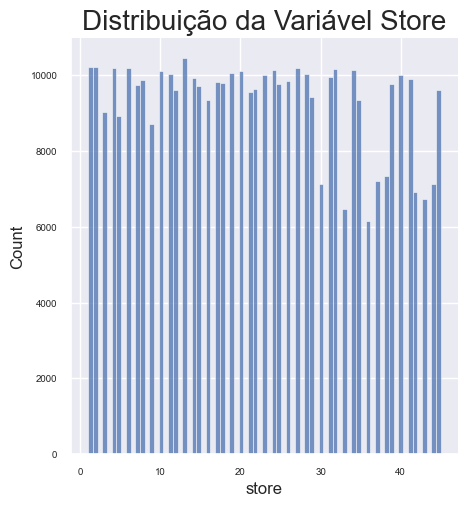

In [38]:
sns.displot(df4["store"], height=5)
plt.xticks(size=7)
plt.yticks(size=7)
plt.title("Distribuição da Variável Store", fontsize=20);

##### **• Departamento**

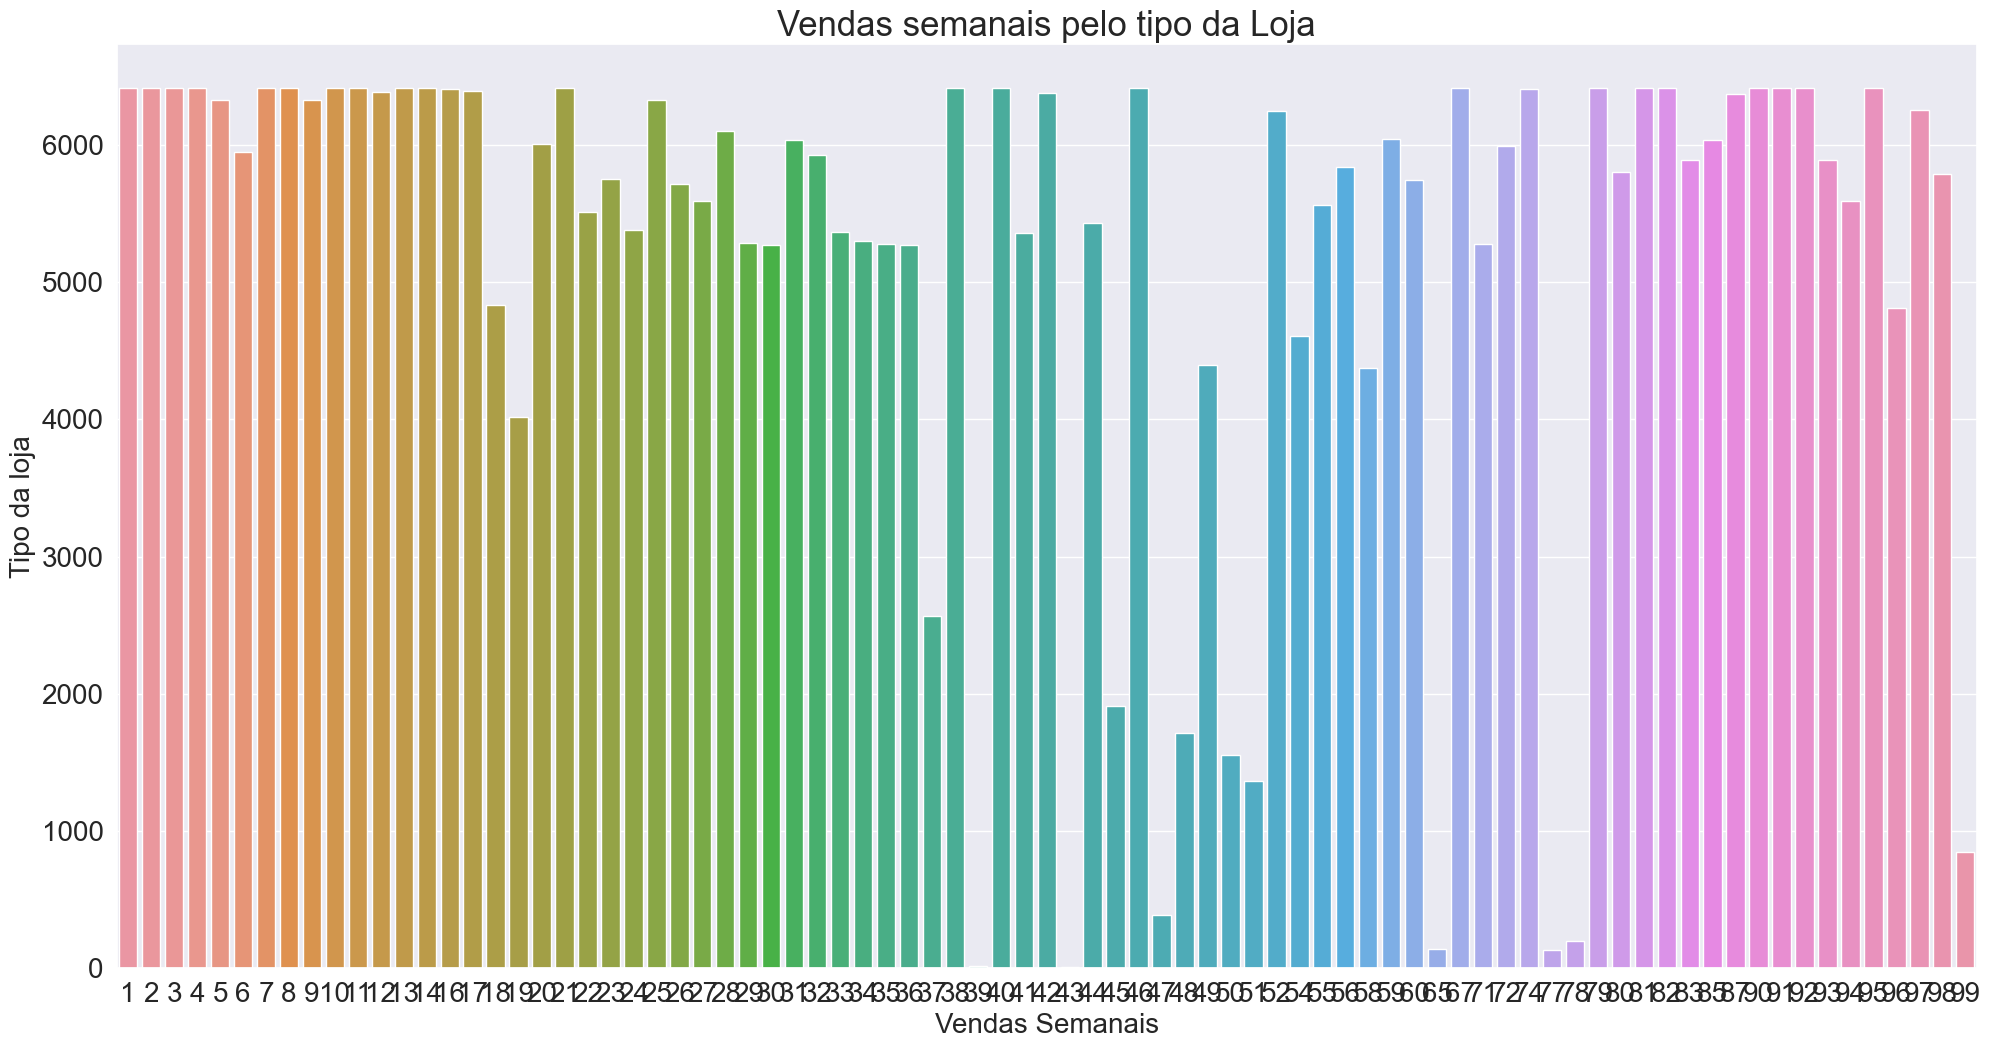

In [39]:
#pd.crosstab(df4["renda_anual"], df4["limite_adicional"]).apply(lambda x: x/x.sum(), axis=1)
plt.figure(figsize=(24,12))
aux4 = df4 [["dept", "weekly_sales"]].groupby("dept").count().reset_index()
#aqui trocamos a posição para ficar melhor de ver no gráfico
sns.barplot( x="dept", y="weekly_sales", data=aux4).set_title("Vendas semanais pelo tipo da Loja", fontsize=25)

plt.ylabel("Tipo da loja", size=20)
plt.xlabel("Vendas Semanais", size=20)
plt.xticks(size=20)
plt.yticks(size=20);

##### **• Is_holiday**

In [40]:
aux2 = df4[["is_holiday", "weekly_sales"]].groupby("is_holiday").count().reset_index()
aux2.head()

,is_holiday,weekly_sales
0,Nao,389434
1,Sim,29293


##### **• CPI**

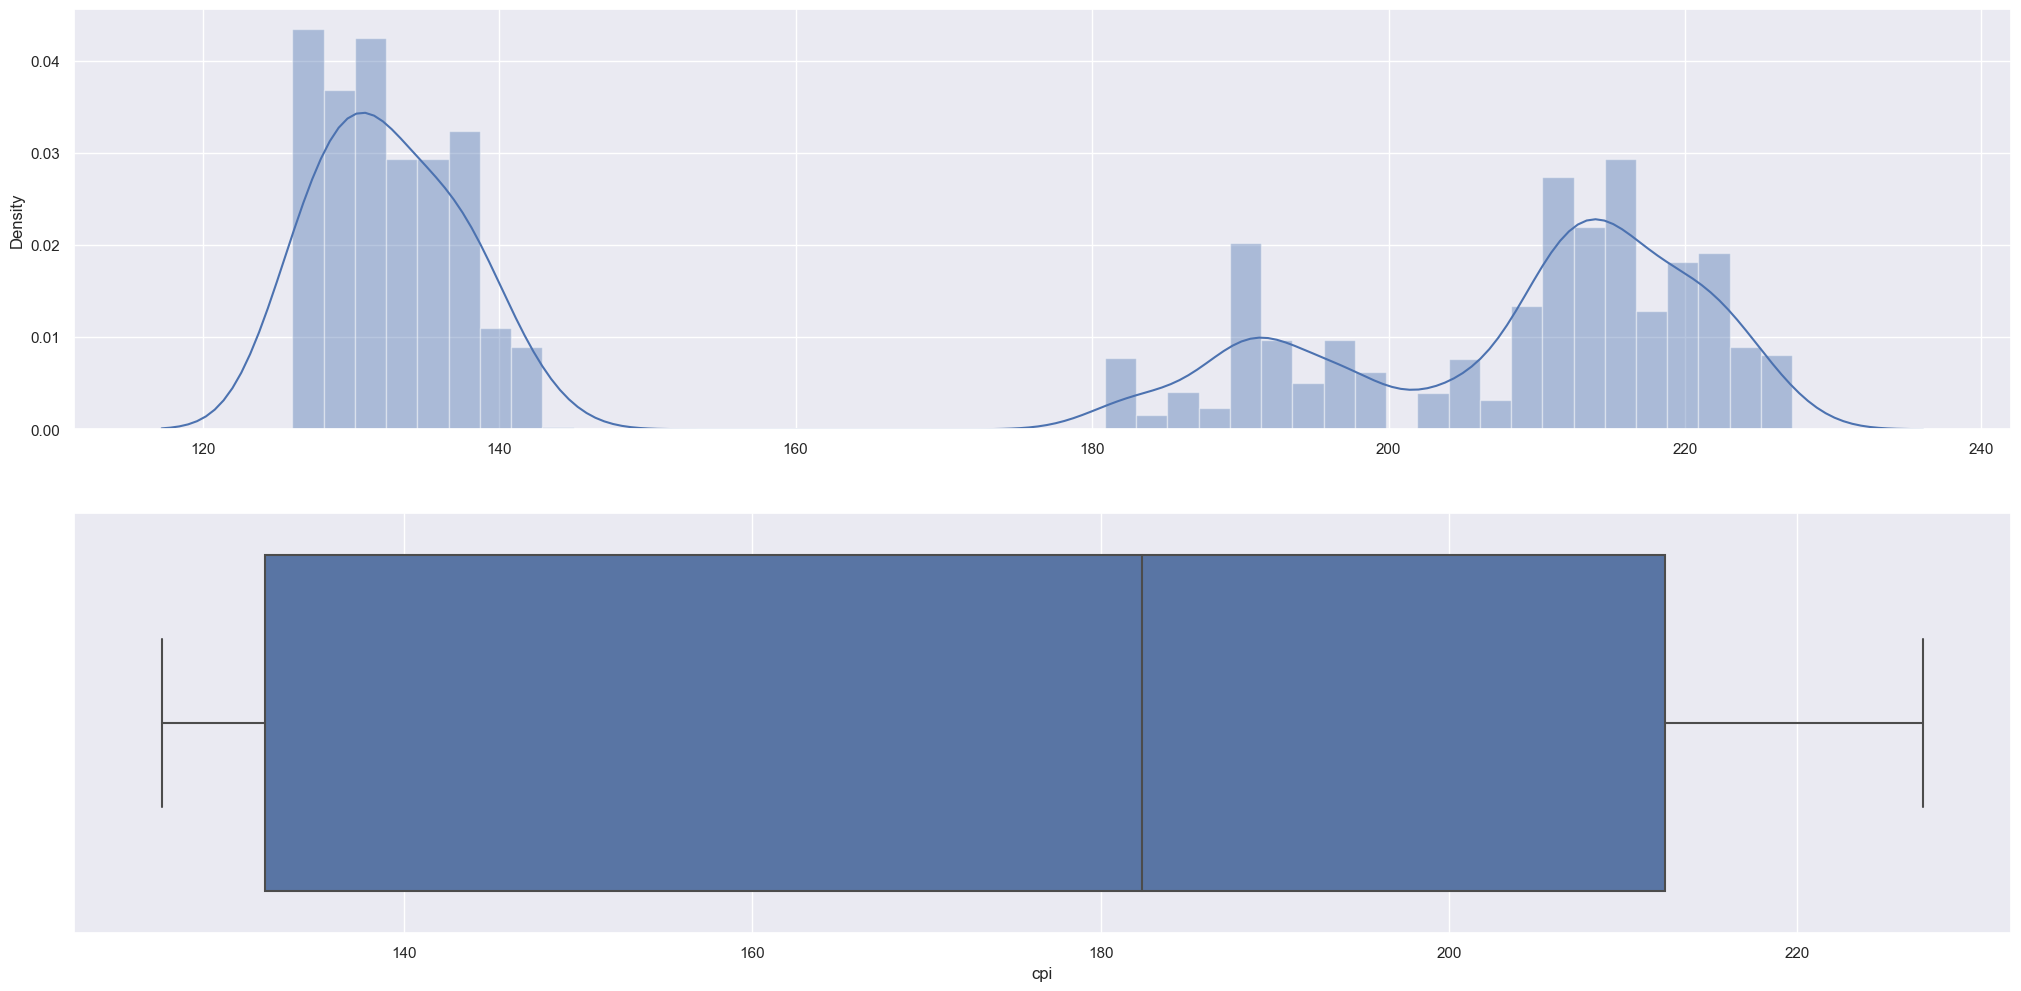

In [41]:
plt.subplot(2,1,1);
sns.distplot(x=df4["cpi"])

plt.subplot(2,1,2);
sns.boxplot(x="cpi", data=df4);

##### **• Unemployment**

In [42]:
df4["unemployment"].median()

7.866

In [43]:
df4["unemployment"].min()

3.879

In [44]:
df4["unemployment"].max()

14.313

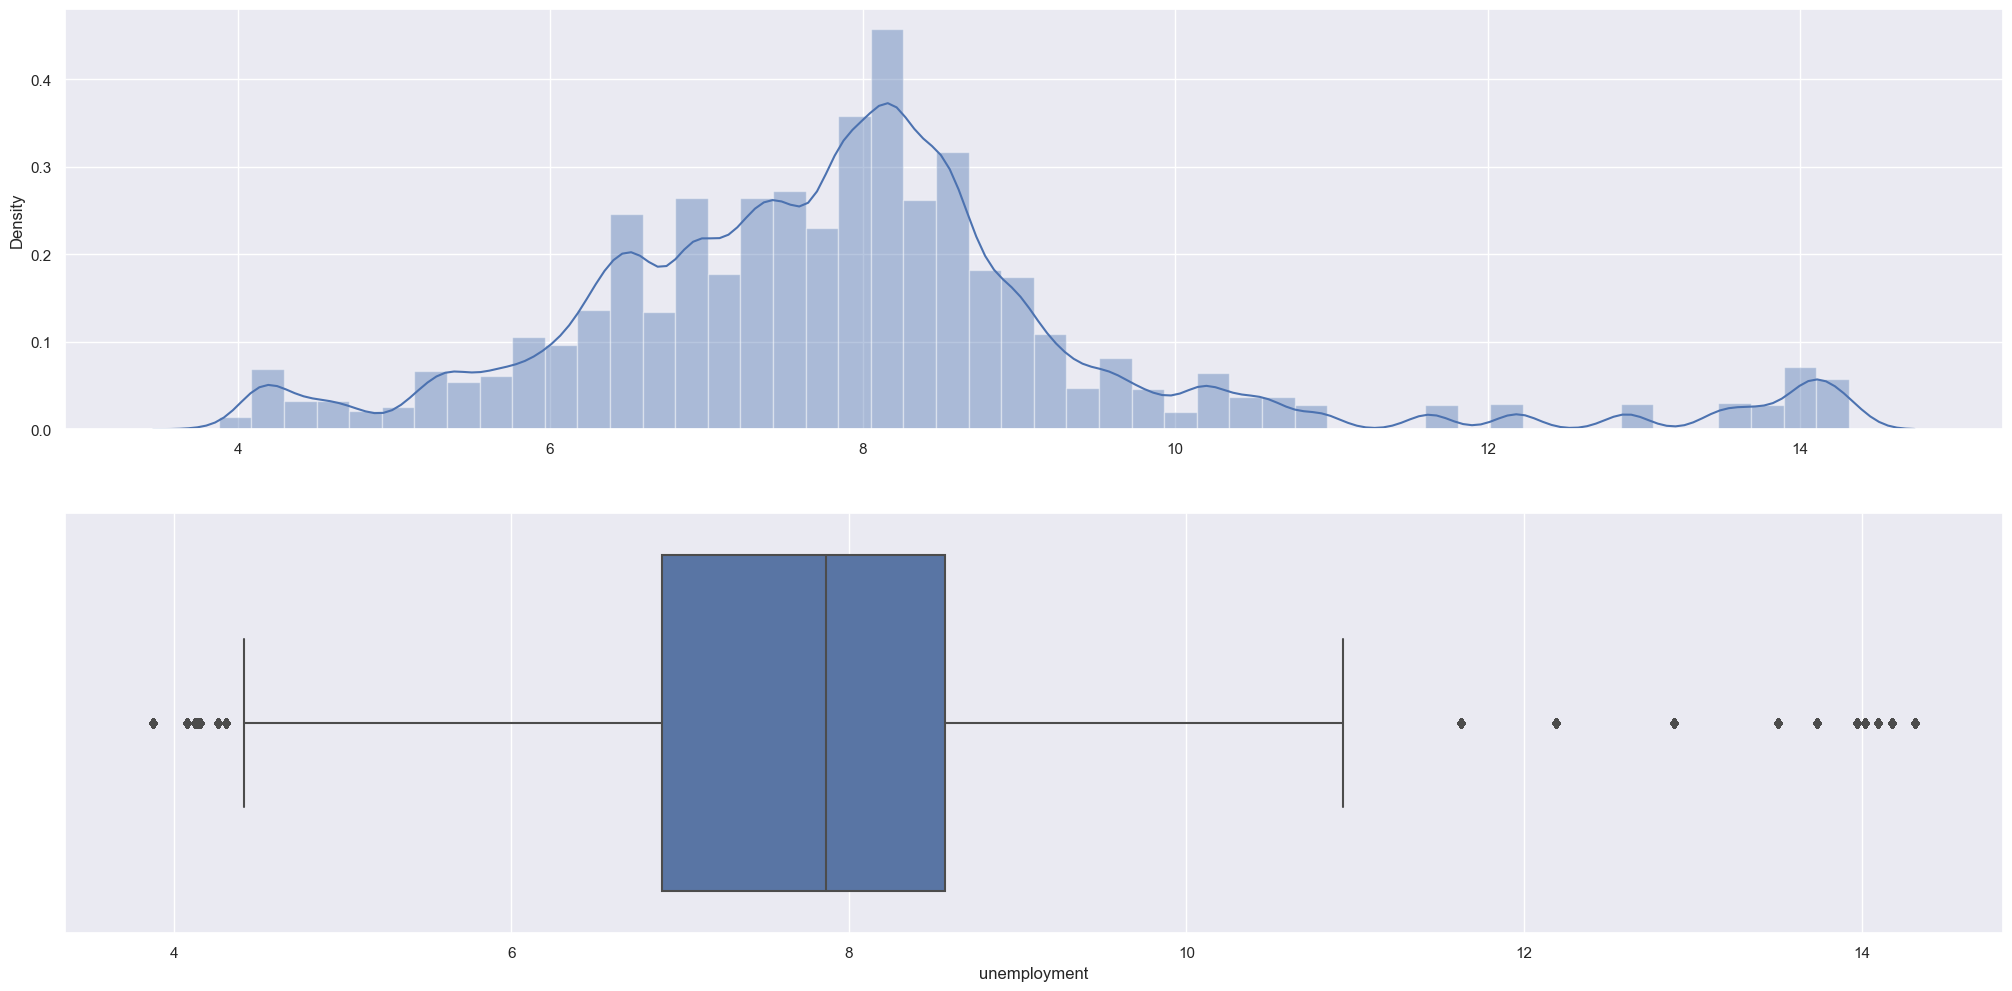

In [45]:
plt.subplot(2,1,1);
sns.distplot(x=df4["unemployment"])

plt.subplot(2,1,2);
sns.boxplot(x="unemployment", data=df4);

##### **• Type**

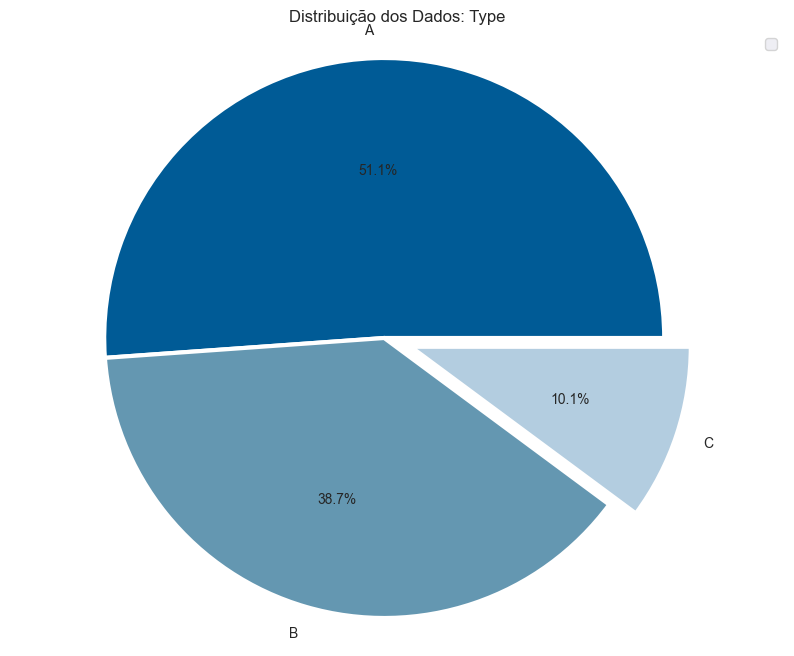

In [46]:
count = df4["type"].value_counts().values
X = df4["type"].value_counts().index
plt.figure(figsize = (10, 8)) 
plt.subplot( )
plt.pie(count, 
        labels = list(X),  
        colors = ["#005b96", "#6497b1", "#b3cde0", "#107dac", "#1ebbd7"],
        labeldistance = 1.1,
        explode = [0, 0, .1],
        autopct="%1.1f%%",
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
        textprops = {"fontsize": 10}, 
        )
plt.axis("equal")
plt.title("Distribuição dos Dados: Type")
plt.legend("");

##### **• Size**

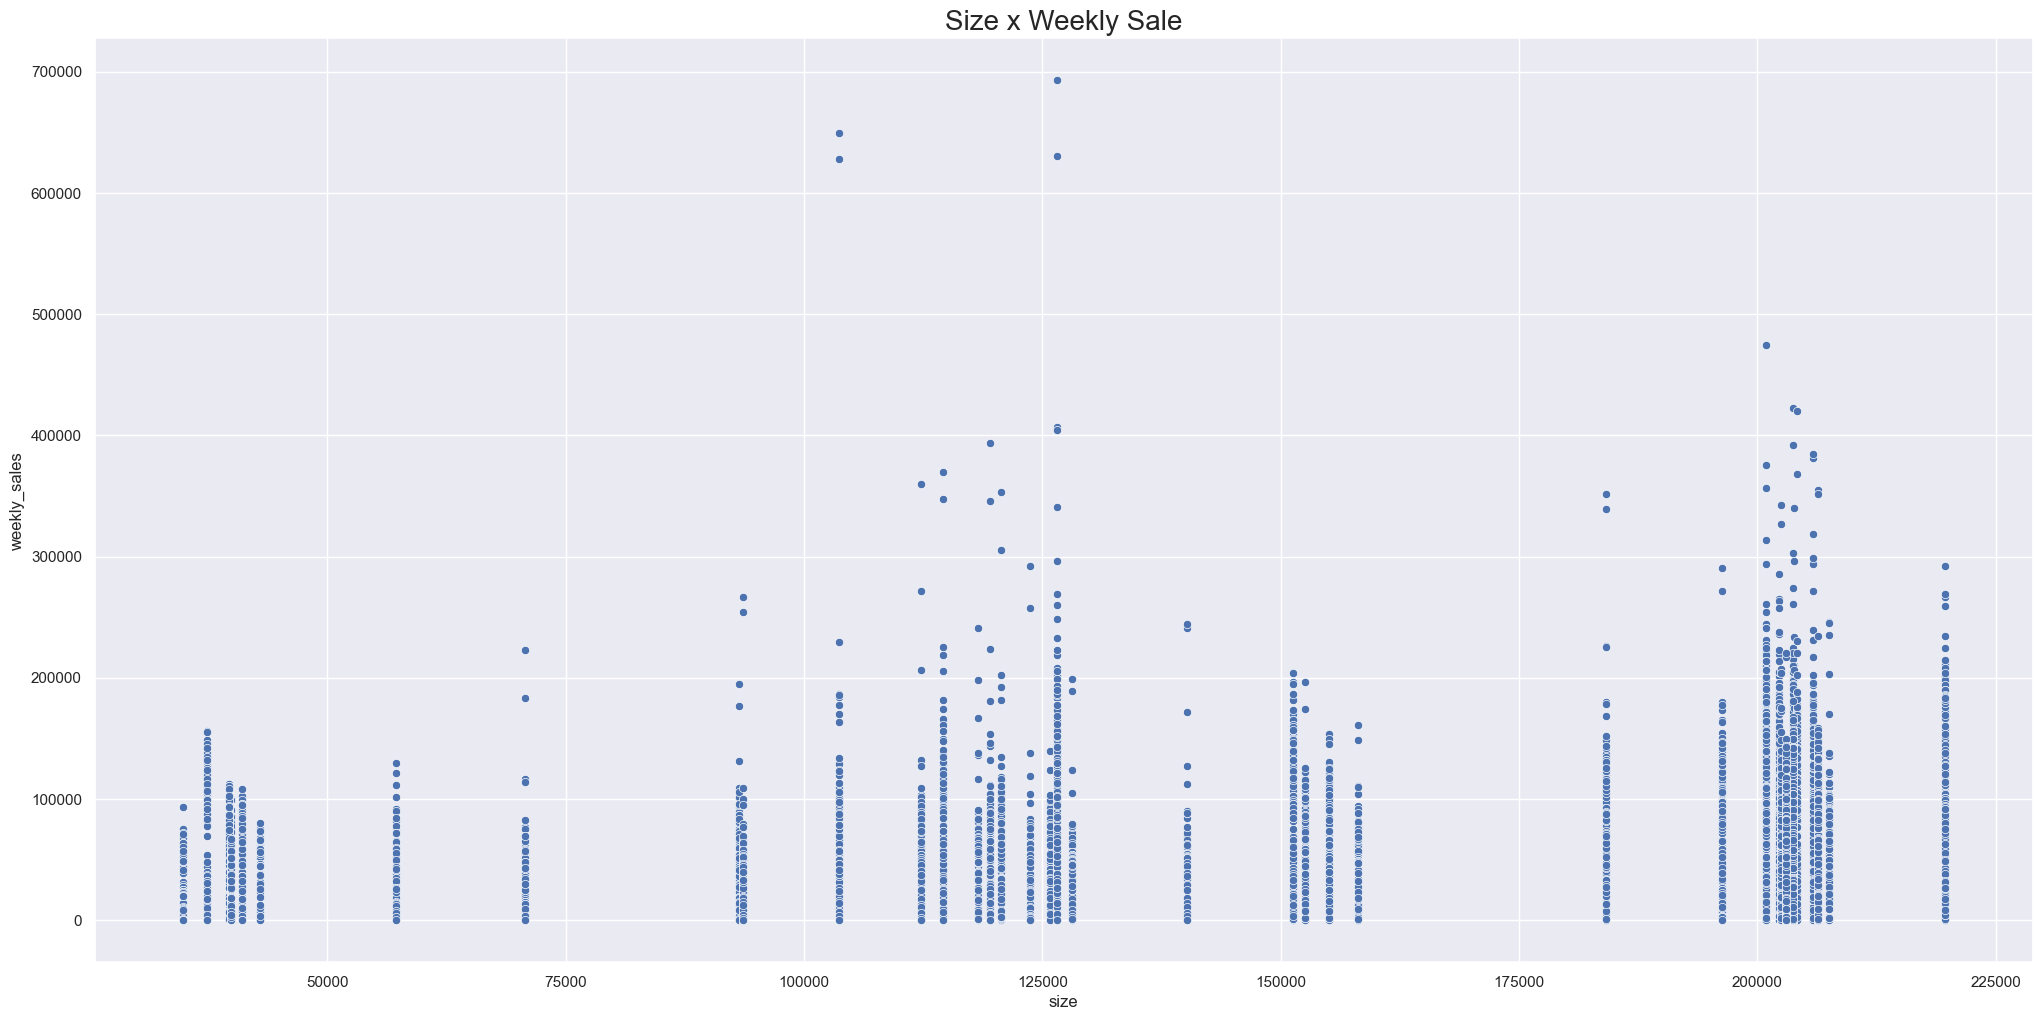

In [47]:
sns.scatterplot(x="size", y="weekly_sales", data=df4).set_title("Size x Weekly Sale", fontsize=20);


### **4.1.2 Numerical variable**

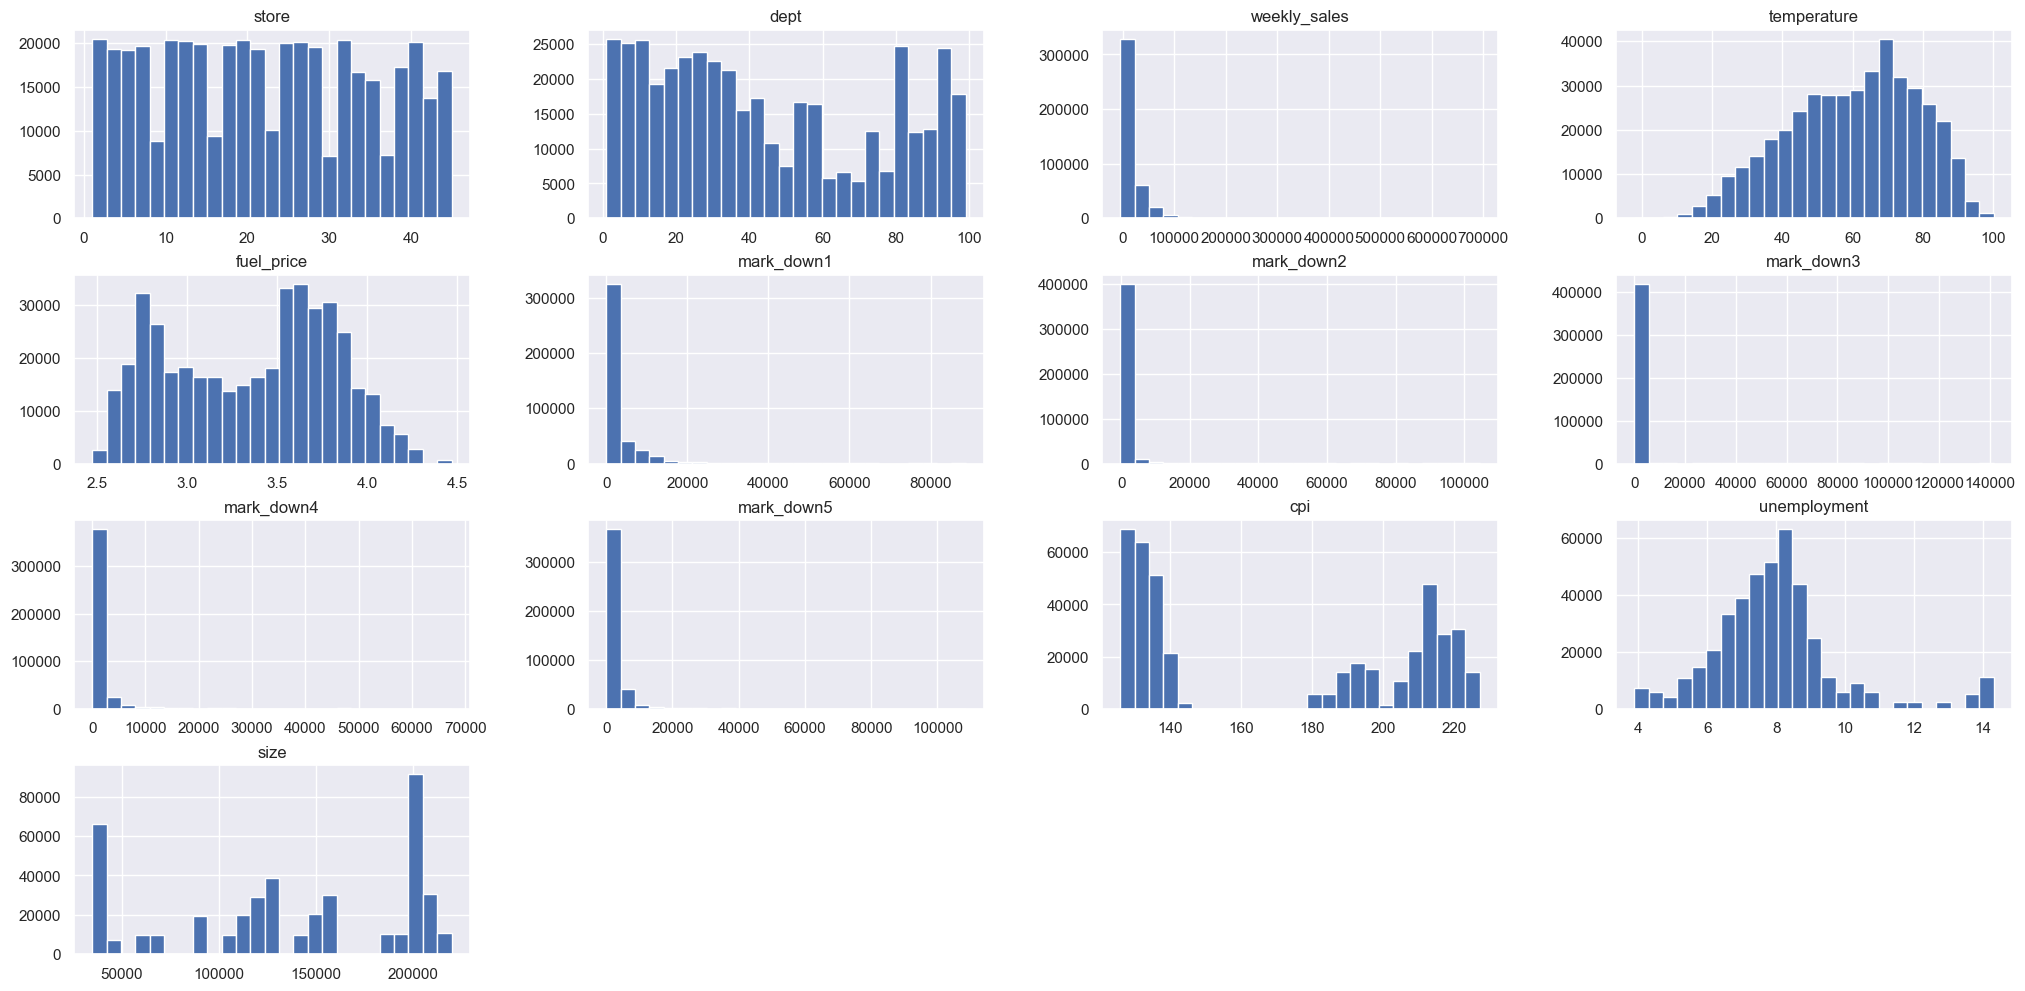

In [48]:
df1_num.hist(bins=25);

### **4.1.3 Categorical variable**

In [49]:
df1_cat.head()

,is_holiday,type
0,Nao,A
1,Nao,A
2,Nao,A
3,Nao,A
4,Nao,A


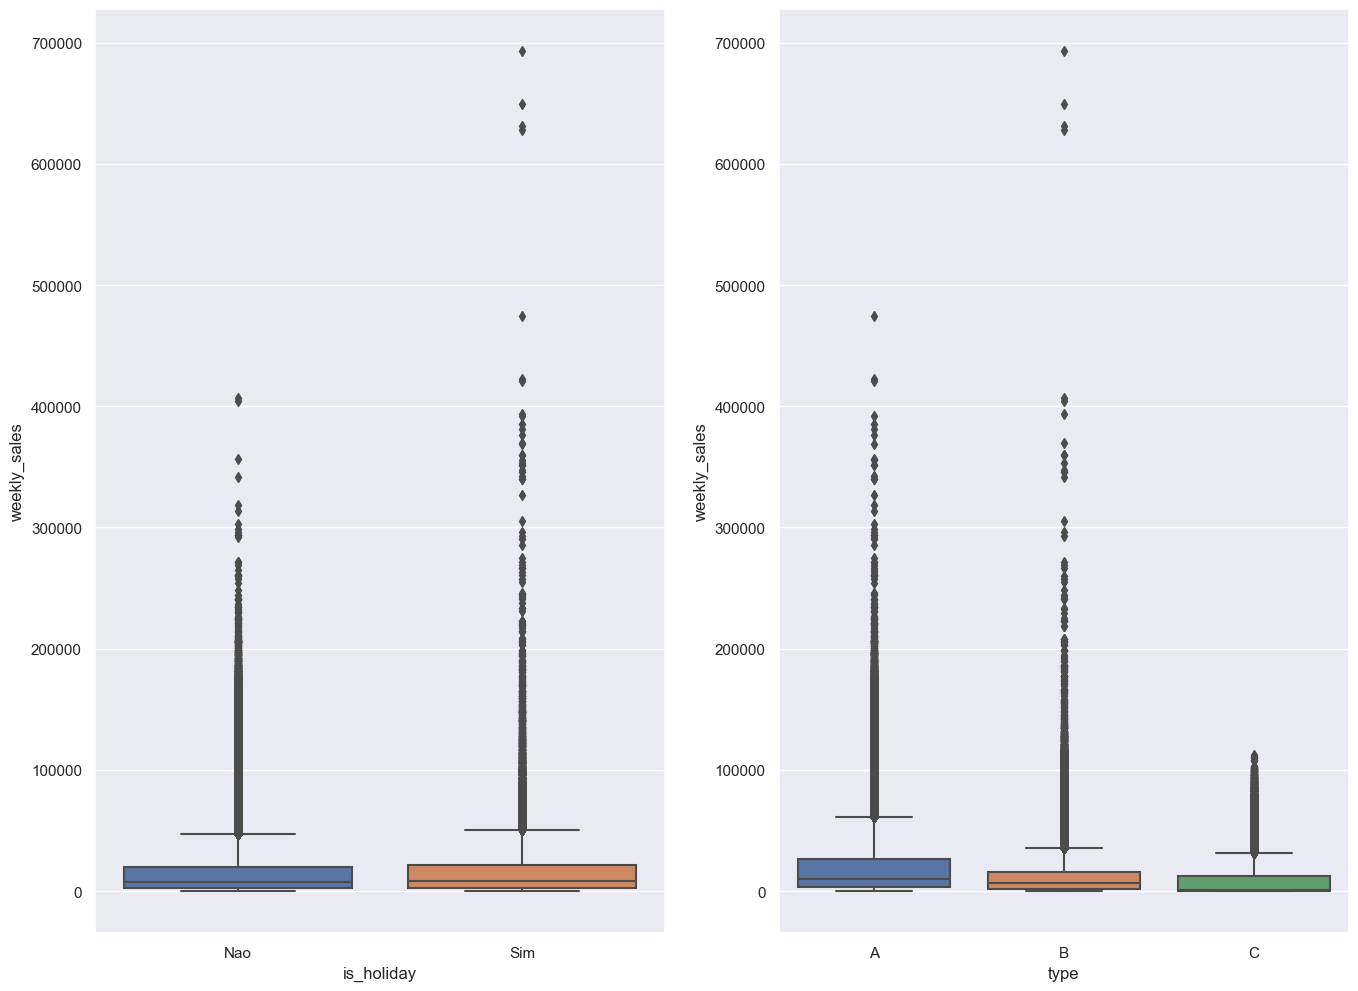

In [50]:
plt.subplot (1, 3, 1)
sns.boxplot(x="is_holiday", y="weekly_sales", data=df4)

plt.subplot (1, 3, 2)
sns.boxplot(x="type", y="weekly_sales", data=df4);

## **4.2 Analise Bivariada**

**descrever a associação entre duas variáveis**

**validação das hipóteses**

##### **H1- Lojas maiores vendem mais.**
Resposta: No gráfico apresentado, a maior distribuição de vendas está nas Lojas com tamanho maior, mas não podemos deixar de observar algumas lojas menores com quantidades de vendas bem acima de outras com tamanho próximo.

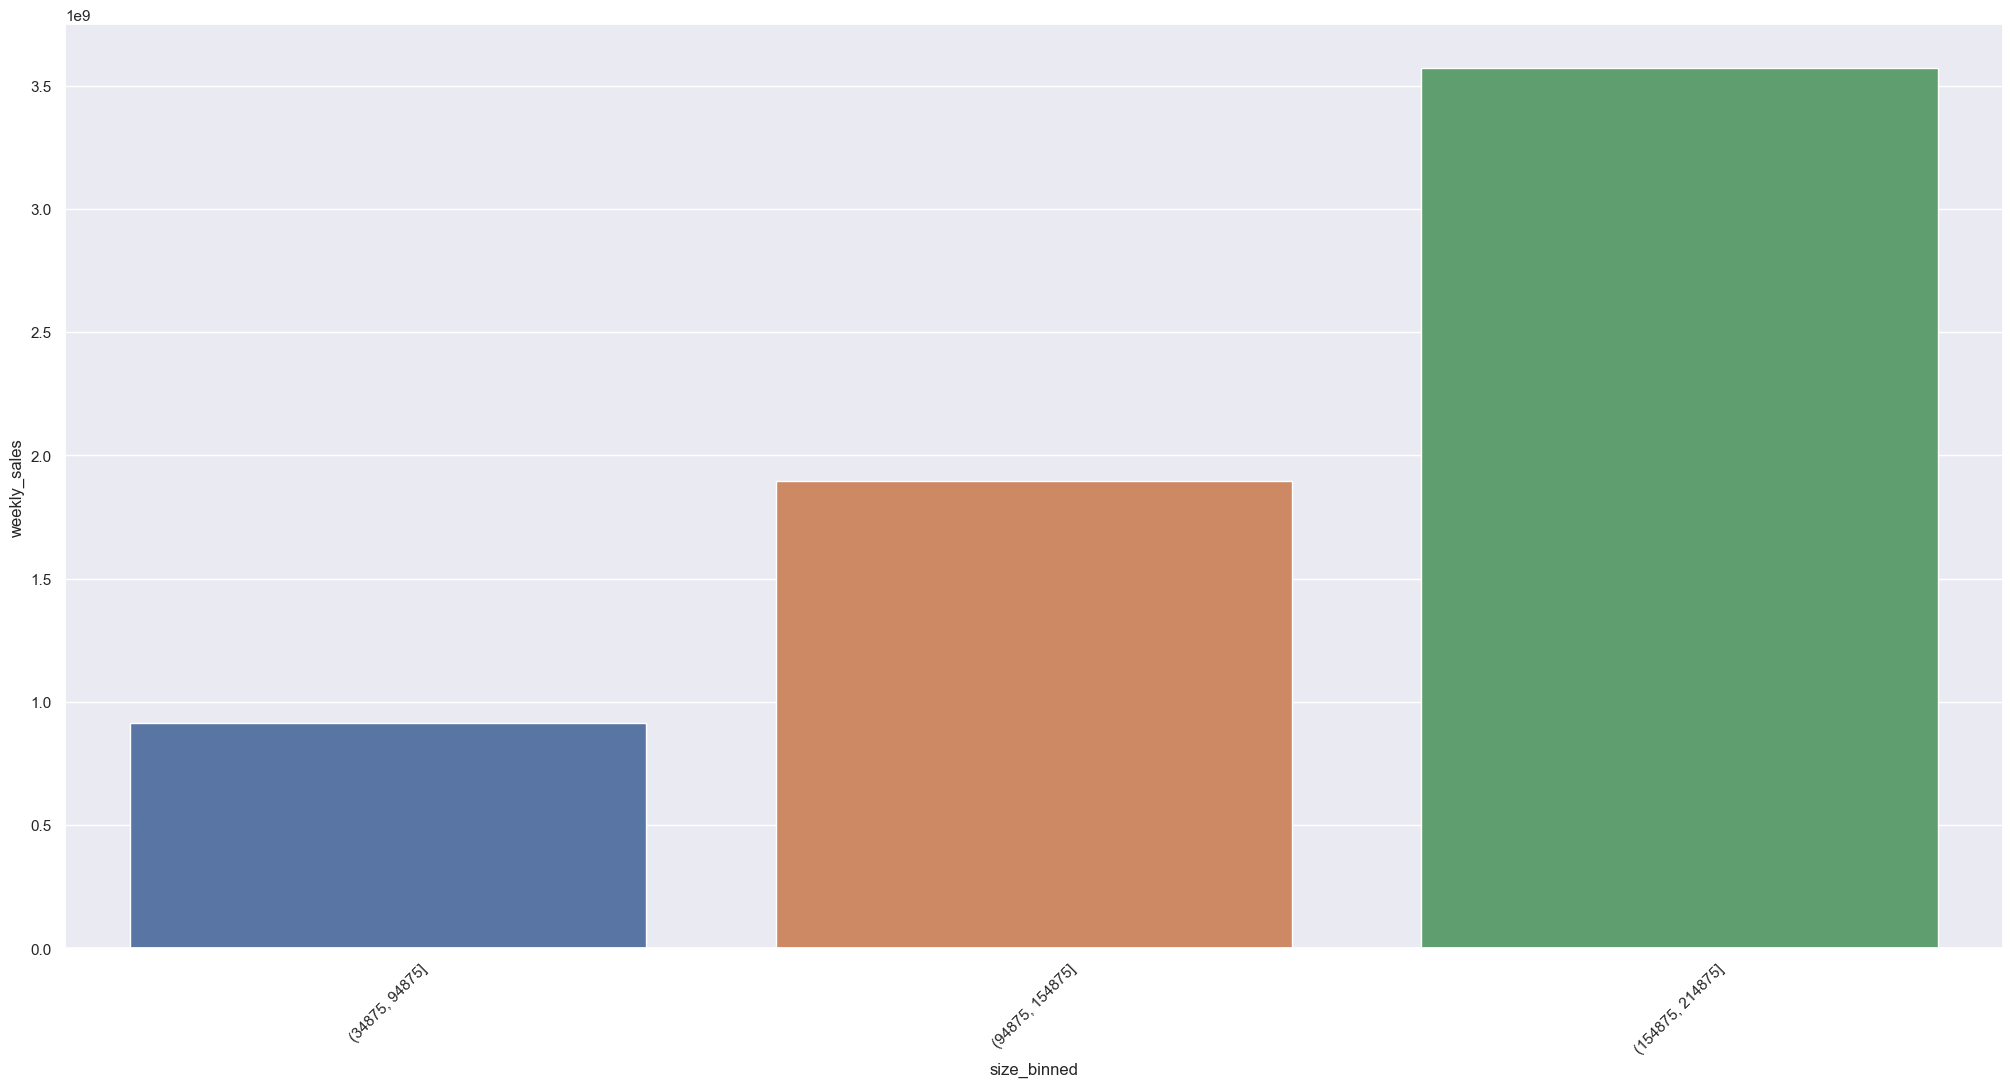

In [51]:
# agrupar o size e weekly_sales
aux1 = df4[["size","weekly_sales"]].groupby("size").sum().reset_index()

bins = list(np.arange(34875,219622,60000))

aux1["size_binned"] = pd.cut(aux1["size"], bins=bins)
aux2 = aux1[["size_binned", "weekly_sales"]].groupby("size_binned").sum().reset_index()

sns.barplot(x="size_binned",y="weekly_sales",data=aux2)
plt.xticks (rotation = 45);

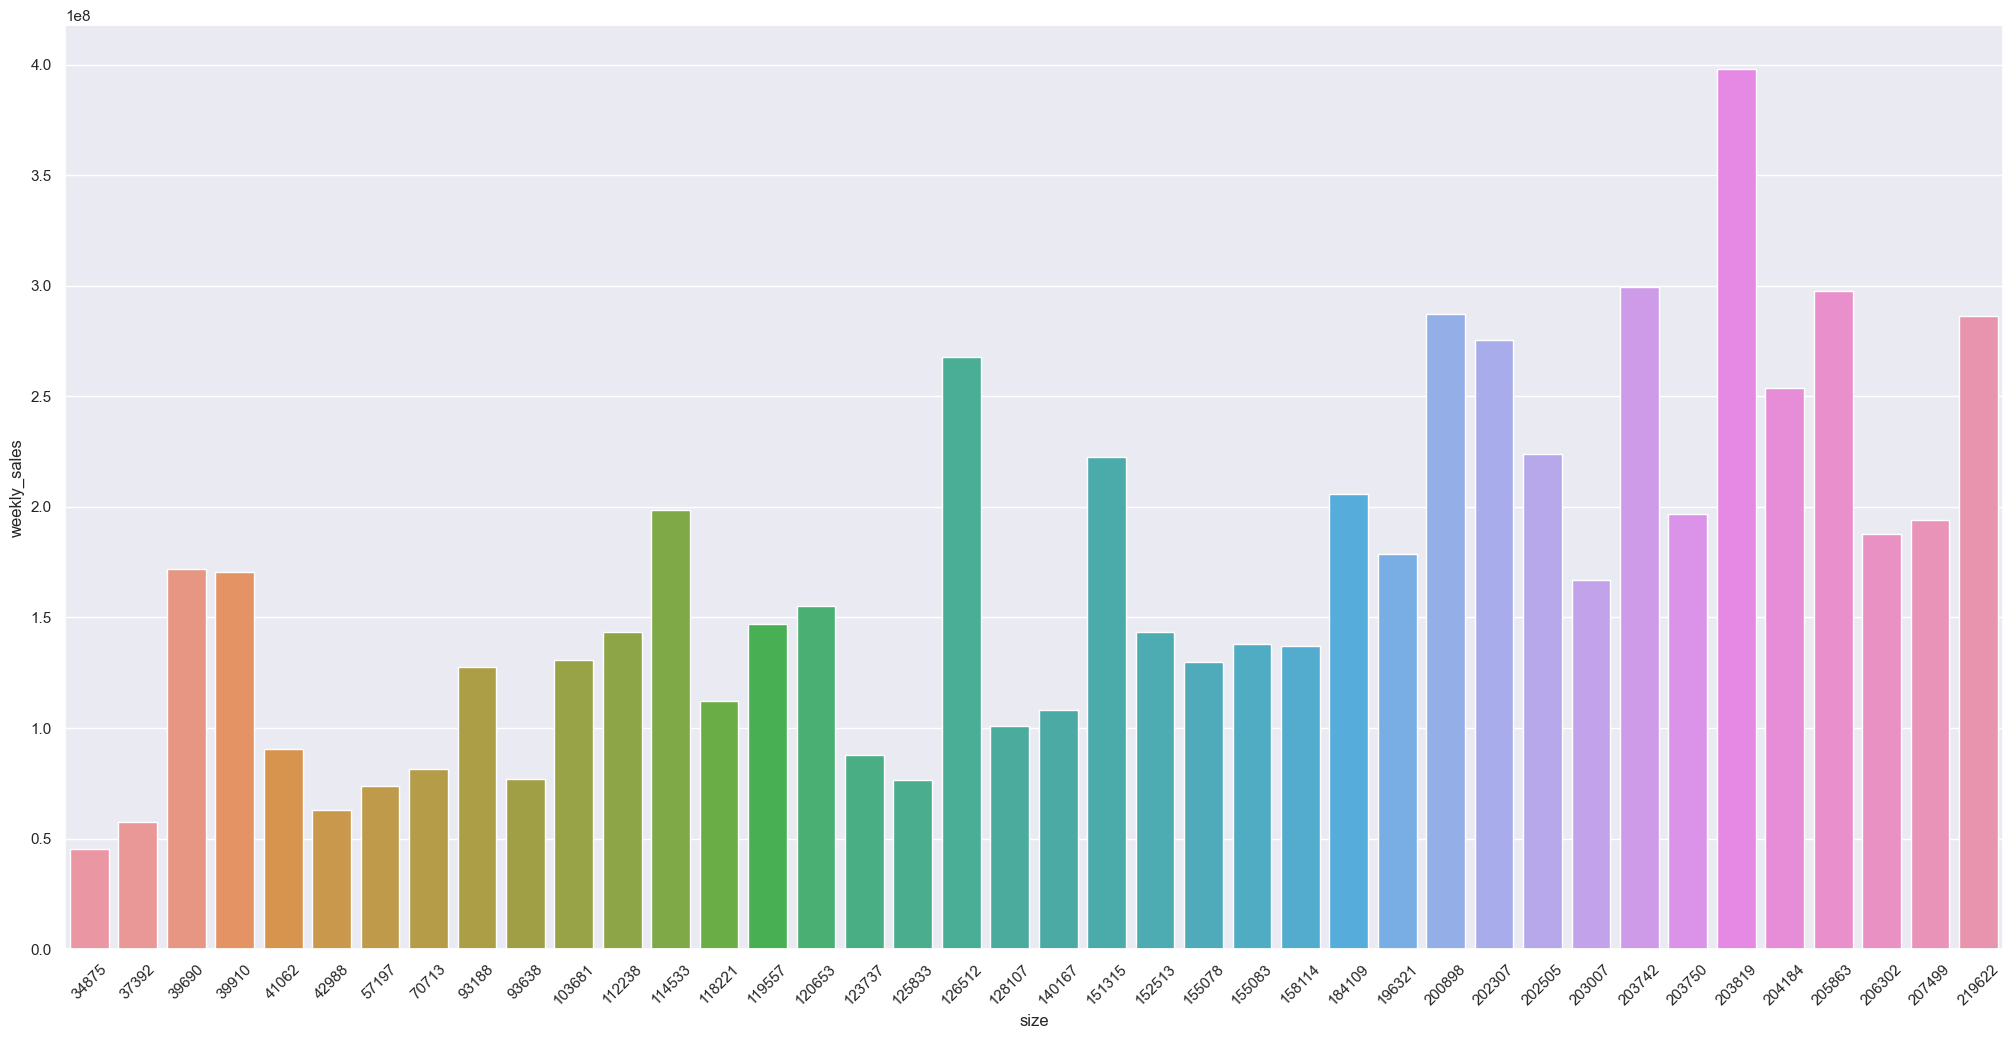

In [52]:
# agrupar o size e weekly_sales
aux1 = df4[["size","weekly_sales"]].groupby("size").sum().reset_index()
sns.barplot(x="size",y="weekly_sales",data=aux1)
plt.xticks (rotation = 45);

##### **H2- Lojas com custo de combustível mais alto vendem menos.**
Resposta: A distribuição não possui muita dispersão quanto as vendas semanais, dessa forma entendo que o custo de combustível da região não é um fator que tenha uma correlação direta com as vendas semanais.

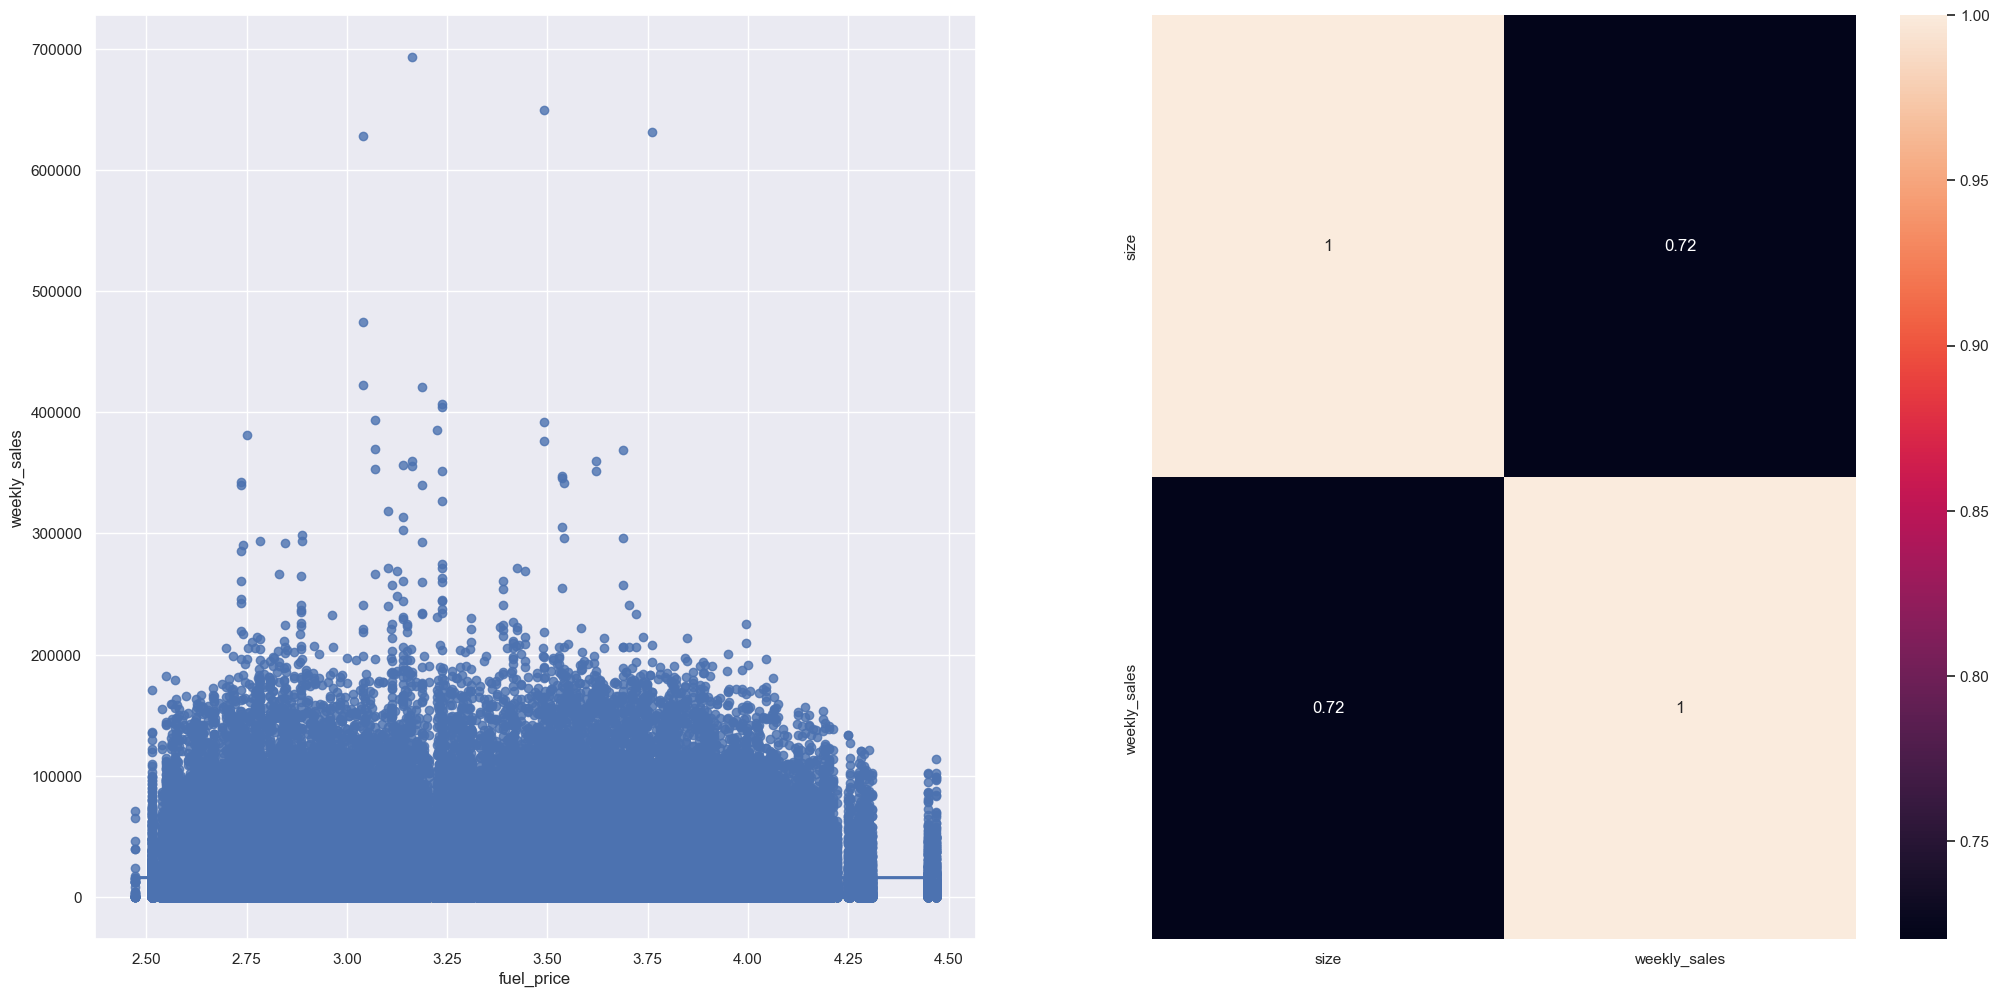

In [53]:
#comportamento de crescimento e decaimento
plt.subplot (1,2,1)
sns.regplot(x="fuel_price", y="weekly_sales", data=df4)

# plot de correlação
plt.subplot (1,2,2)
x=sns.heatmap (aux1.corr(method="pearson"),annot=True);

##### **H3- Dias mais quentes tendem a vender menos.**
Resposta: O comportamento de vendas é impactado com temperaturas abaixo de 0. Apesar do gráfico mostrar distribuições de vendas maior com temperaturas mais altas, não é obsevado grandes alterações no comportamento das vendas entre temperaturas de 12 a 35 graus celsius.

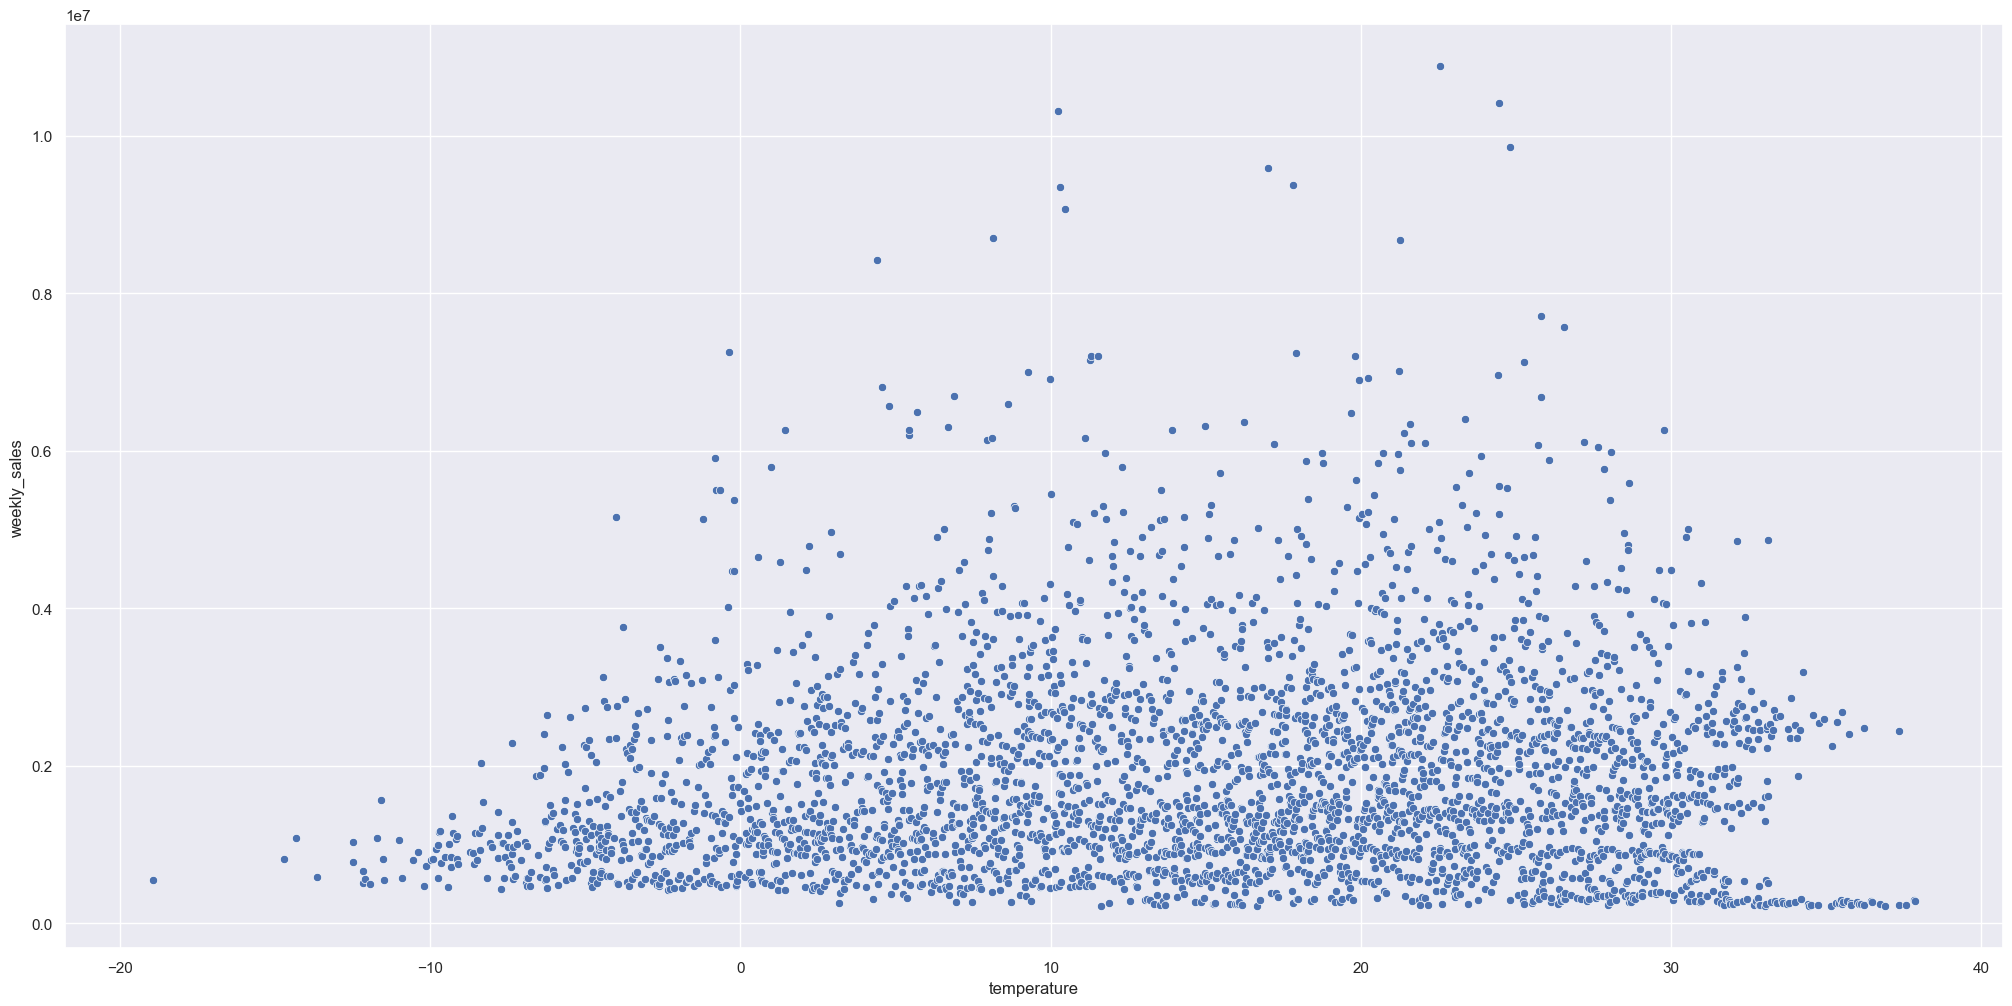

In [54]:
aux5 = df4[["temperature", "weekly_sales"]].groupby("temperature").sum().reset_index()
sns.scatterplot(x="temperature",y="weekly_sales",data=aux5);

In [55]:
aux5_2 = df4[["weekly_sales", "temperature"]].groupby(["temperature"]).sum().reset_index()
aux5_2 = aux5_2.sort_values(by = ["weekly_sales", "temperature"], ascending=[False,True])
aux5_2.head(10)

,temperature,weekly_sales
2530,22.566667,10886403.45
2739,24.461111,10418867.71
1206,10.238889,10312827.06
2773,24.816667,9857275.53
1880,17.011111,9594043.10
1969,17.805556,9378463.94
1214,10.311111,9352401.33
1229,10.450000,9067177.20
1010,8.144444,8702080.03
2378,21.266667,8683625.30


##### **H4- Meses com variação do índice de preços ao consumidor maiores deveriam vender menos.**
Resposta: O aumento da variação do índice de preços não afetou nas vendas, o gráfico demonstra que ao passar do tempo o comportamento de vendas foi exponencial.

In [56]:
df4["cpi"].unique()

array([211.0963582, 211.2421698, 211.2891429, ..., 214.7212488,
       214.7415392, 191.1685192])

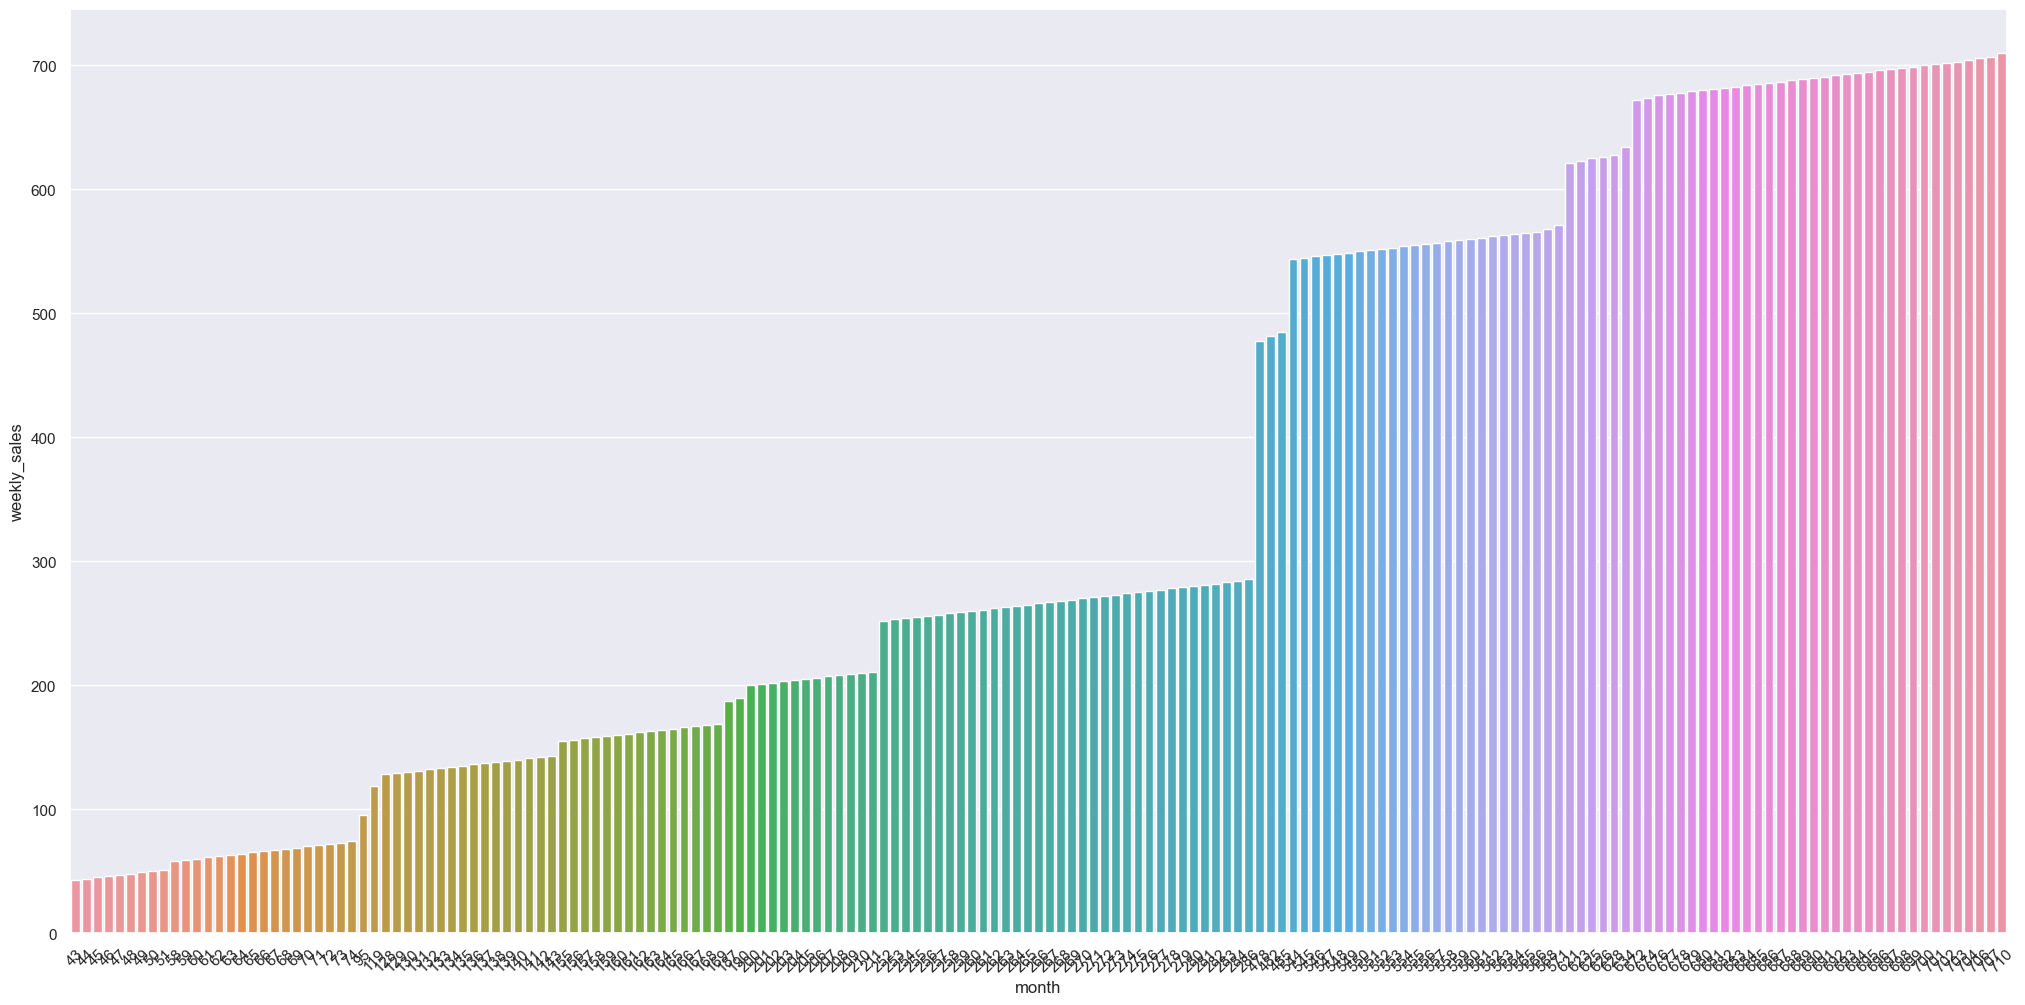

In [57]:
aux5 = df4[["month","cpi","weekly_sales"]].groupby("cpi").count().reset_index()
sns.barplot(x="month",y="weekly_sales",data=aux5)
plt.xticks (rotation = 45);

In [58]:
#plt.plot(df4["date"], df4["cpi"]);

aux6 = df4[["date", "cpi", "weekly_sales"]].groupby(["date", "cpi"]).sum().reset_index()
aux6 = aux6.sort_values(by = ["cpi", "date", "weekly_sales"], ascending=[True,False,True])
aux6.head(10)


,date,cpi,weekly_sales
405,2010-08-13,126.064000,11186677.11
420,2010-08-20,126.076645,11236542.21
390,2010-08-06,126.085452,11617224.06
435,2010-08-27,126.089290,10644405.86
450,2010-09-03,126.101935,11447358.36
375,2010-07-30,126.106903,10543650.27
270,2010-06-11,126.111903,11470662.95
285,2010-06-18,126.114000,11245271.94
465,2010-09-10,126.114581,11122414.16
300,2010-06-25,126.126600,10918102.79


##### **H5- Ano em que a taxa de desemprego foi maior deveria vender menos.**
Resposta: Ao longo dos anos o gráfico mostra que ocorreu um pequeno aumento de vendas mesmo com a taxa de desemprego alta.

In [59]:
df4["year"].unique()

array([2010, 2011, 2012])

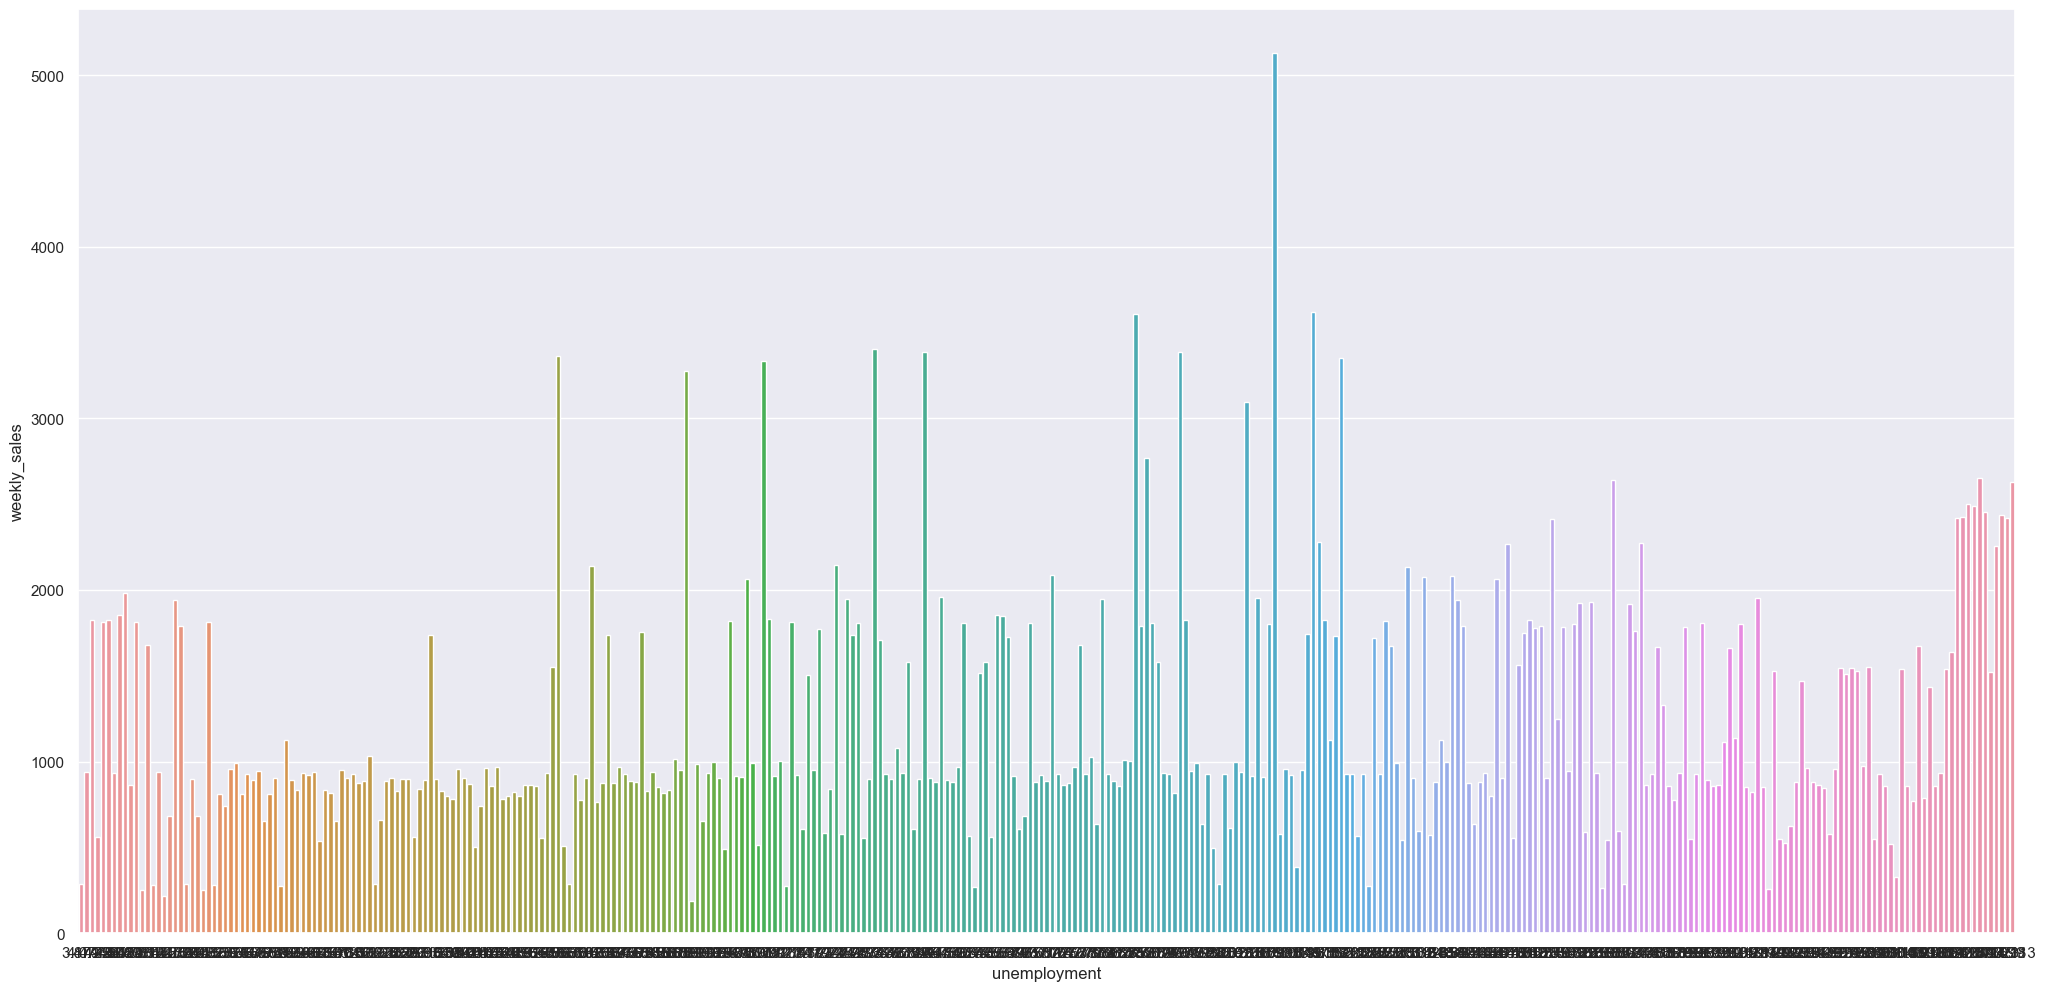

In [60]:
# agrupar o taxa desemprego e weekly_sales
aux1 = df4[["unemployment","year","weekly_sales"]].groupby("unemployment").count().reset_index()
sns.barplot(x="unemployment",y="weekly_sales",data=aux1);
#plt.xticks (rotation = 90);

##### **H6- Lojas em dias de promoção vendem mais.**
Resposta: Apesar de vermos picos de vendas, considerando o período com marcação de promoção, o comportamento de vendas não mantêm os níveis altos, pois observamos muitas quedas após esses picos de vendas.

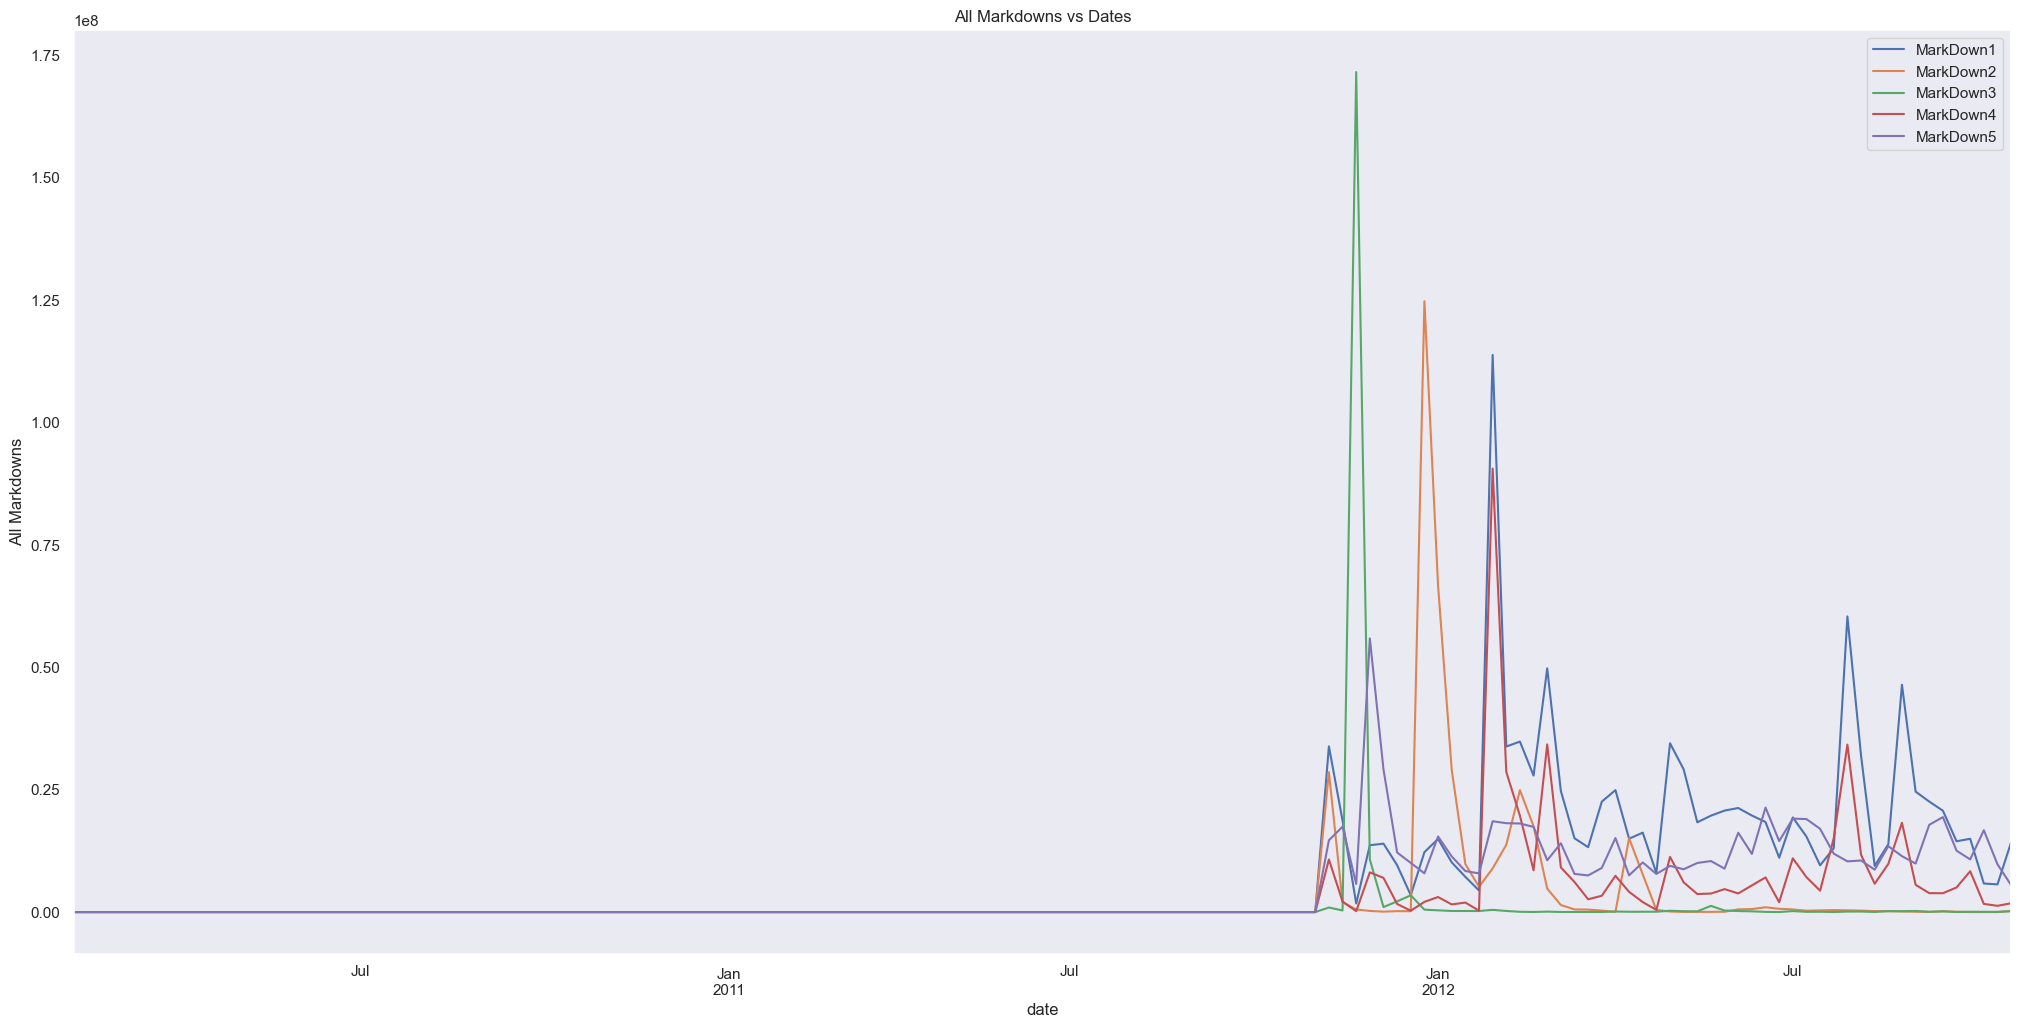

In [61]:
df4.groupby(["date"])["mark_down1"].sum().plot(label="MarkDown1")
df4.groupby(["date"])["mark_down2"].sum().plot(label="MarkDown2")
df4.groupby(["date"])["mark_down3"].sum().plot(label="MarkDown3")
df4.groupby(["date"])["mark_down4"].sum().plot(label="MarkDown4")
df4.groupby(["date"])["mark_down5"].sum().plot(label="MarkDown5")

plt.grid()
plt.title("All Markdowns vs Dates")  
plt.ylabel("All Markdowns")
plt.legend();

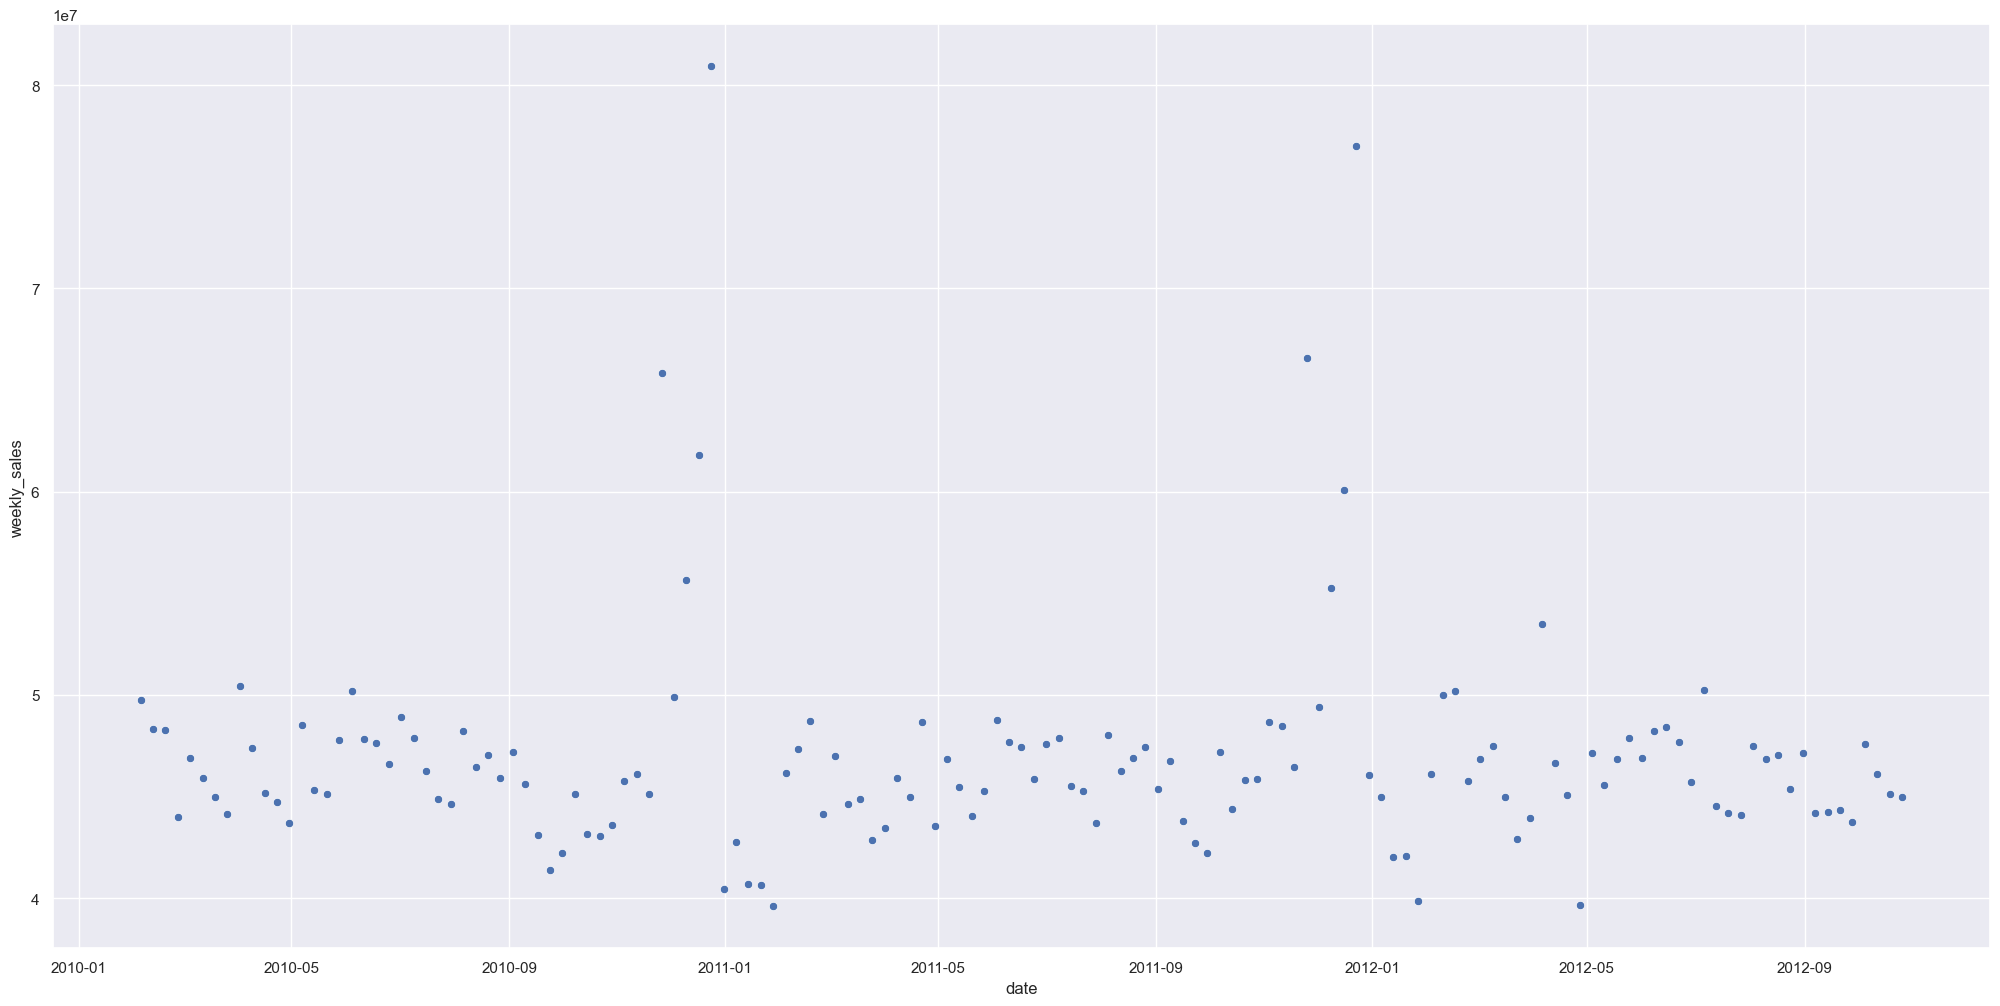

In [62]:
# gráfico de pontos, para perceber o comportamento do consumidor sobre as vendas por dia
aux2 = df4[["date", "weekly_sales"]].groupby("date").sum().reset_index()
sns.scatterplot(x="date",y="weekly_sales",data=aux2);

##### **H7- Lojas abertas durante período de feriados importantes(super bowl, dia do trabalhador, natal, ação de graças...) deveriam vender mais.**
Resposta: Os dados demonstram que a maior quantidade de vendas ocorrem em semanas sem feriado, apesar disso percebemos que a média de vendas nas semanas com feriados é de 1163.14 maior que a média de vendas nas semanas sem feriado. Essa visão agrupada, esconde um comportamento interessante, nos feriados de fevereiro e setembro ocorre um pequeno aumento nas vendas. Já em novembro, o comportamento das vendas tem um aumento considerável, enquanto em dezembro mostra um comportamento oposto, com baixas expressivas nas vendas. Embora não haja dados suficientes, podemos supor que as vendas para os feriados de dezembro são antecipadas em novembro, no feriado de Thanksgiving que antecede a Black Friday. 

In [67]:
df4["is_holiday"] = df4["is_holiday"].replace(["Nao"],0)
df4["is_holiday"] = df4["is_holiday"].replace(["Sim"],1)

In [68]:
df4[df4['is_holiday']==0]['weekly_sales'].describe()

count    389434.000000
mean      15944.465963
std       22343.199043
min           0.000000
25%        2115.510000
50%        7632.320000
75%       20183.130000
max      406988.630000
Name: weekly_sales, dtype: float64

In [69]:
df4[df4['is_holiday']==1]['weekly_sales'].describe()

count     29293.000000
mean      17108.099010
std       27279.158431
min           0.000000
25%        2124.720000
50%        8004.350000
75%       21278.830000
max      693099.360000
Name: weekly_sales, dtype: float64

In [70]:
df4["weekly_sales"].max()

693099.36

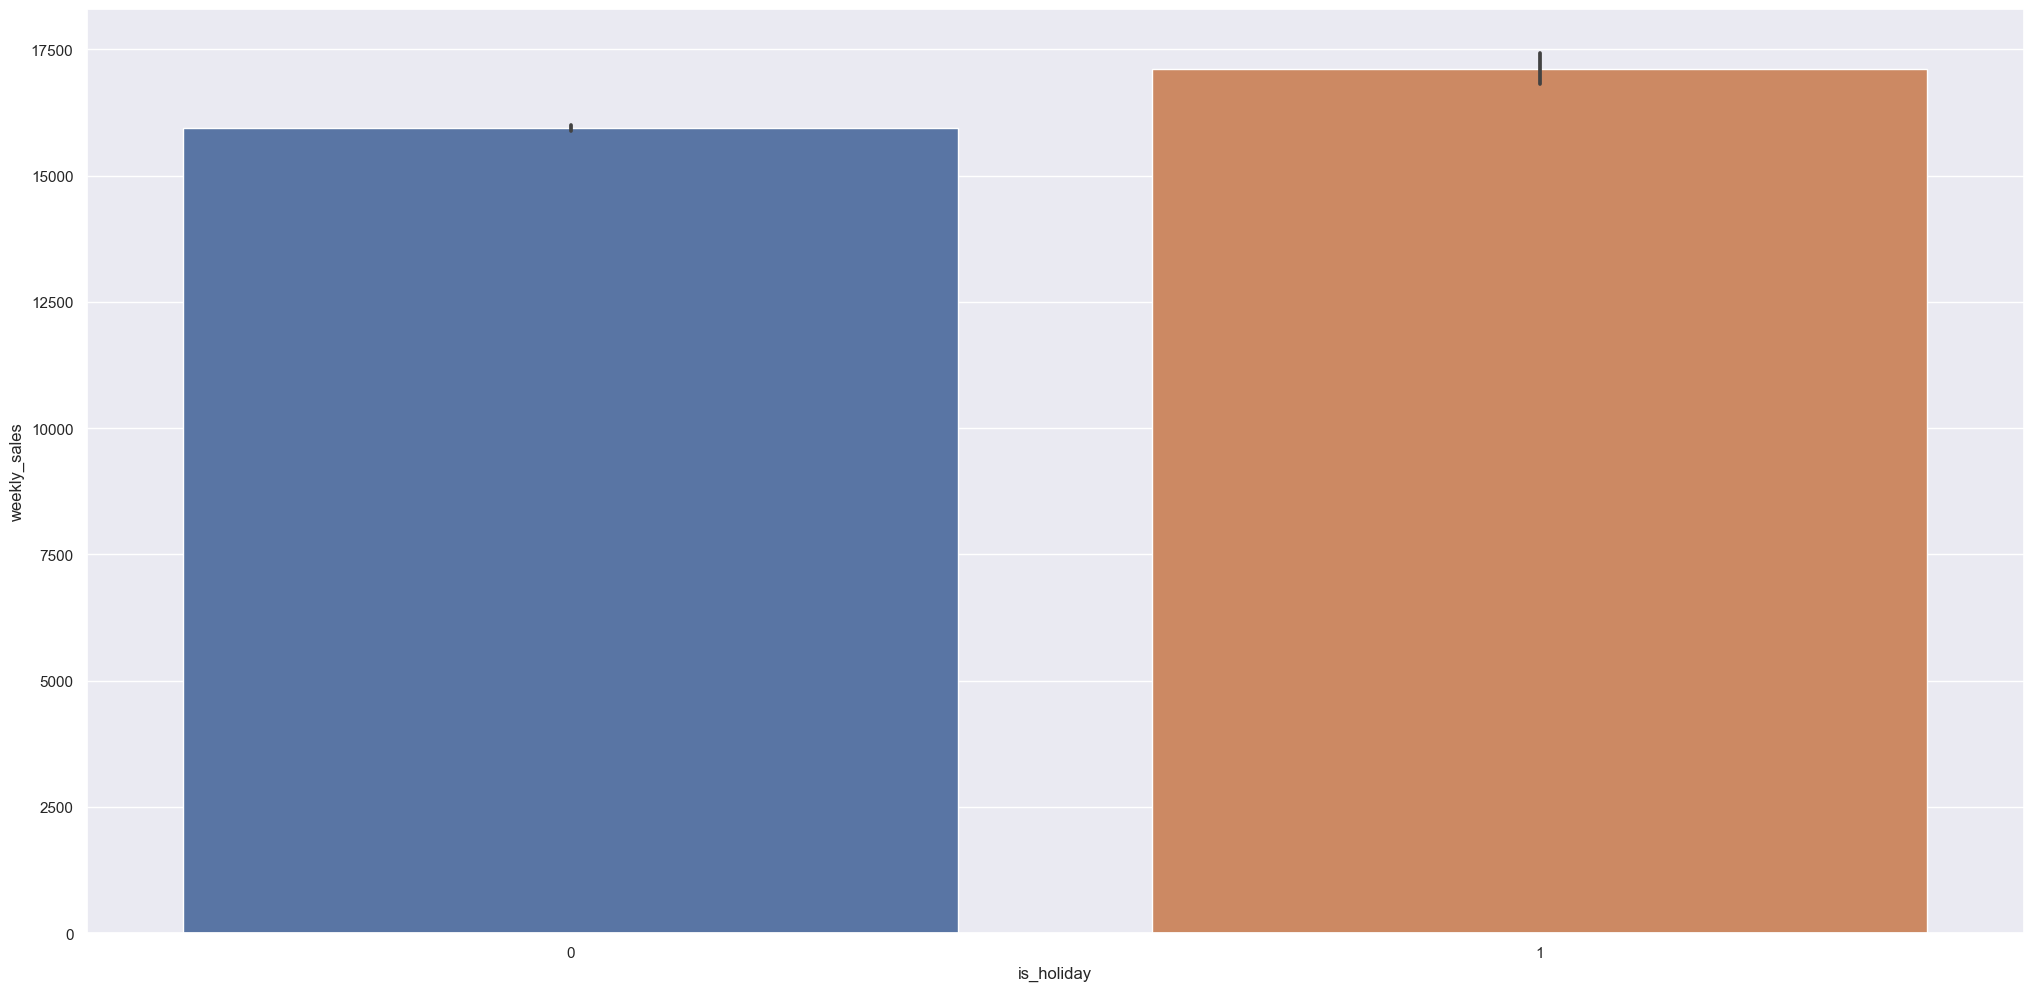

In [71]:
sns.barplot( x='is_holiday', y='weekly_sales', data=df4);


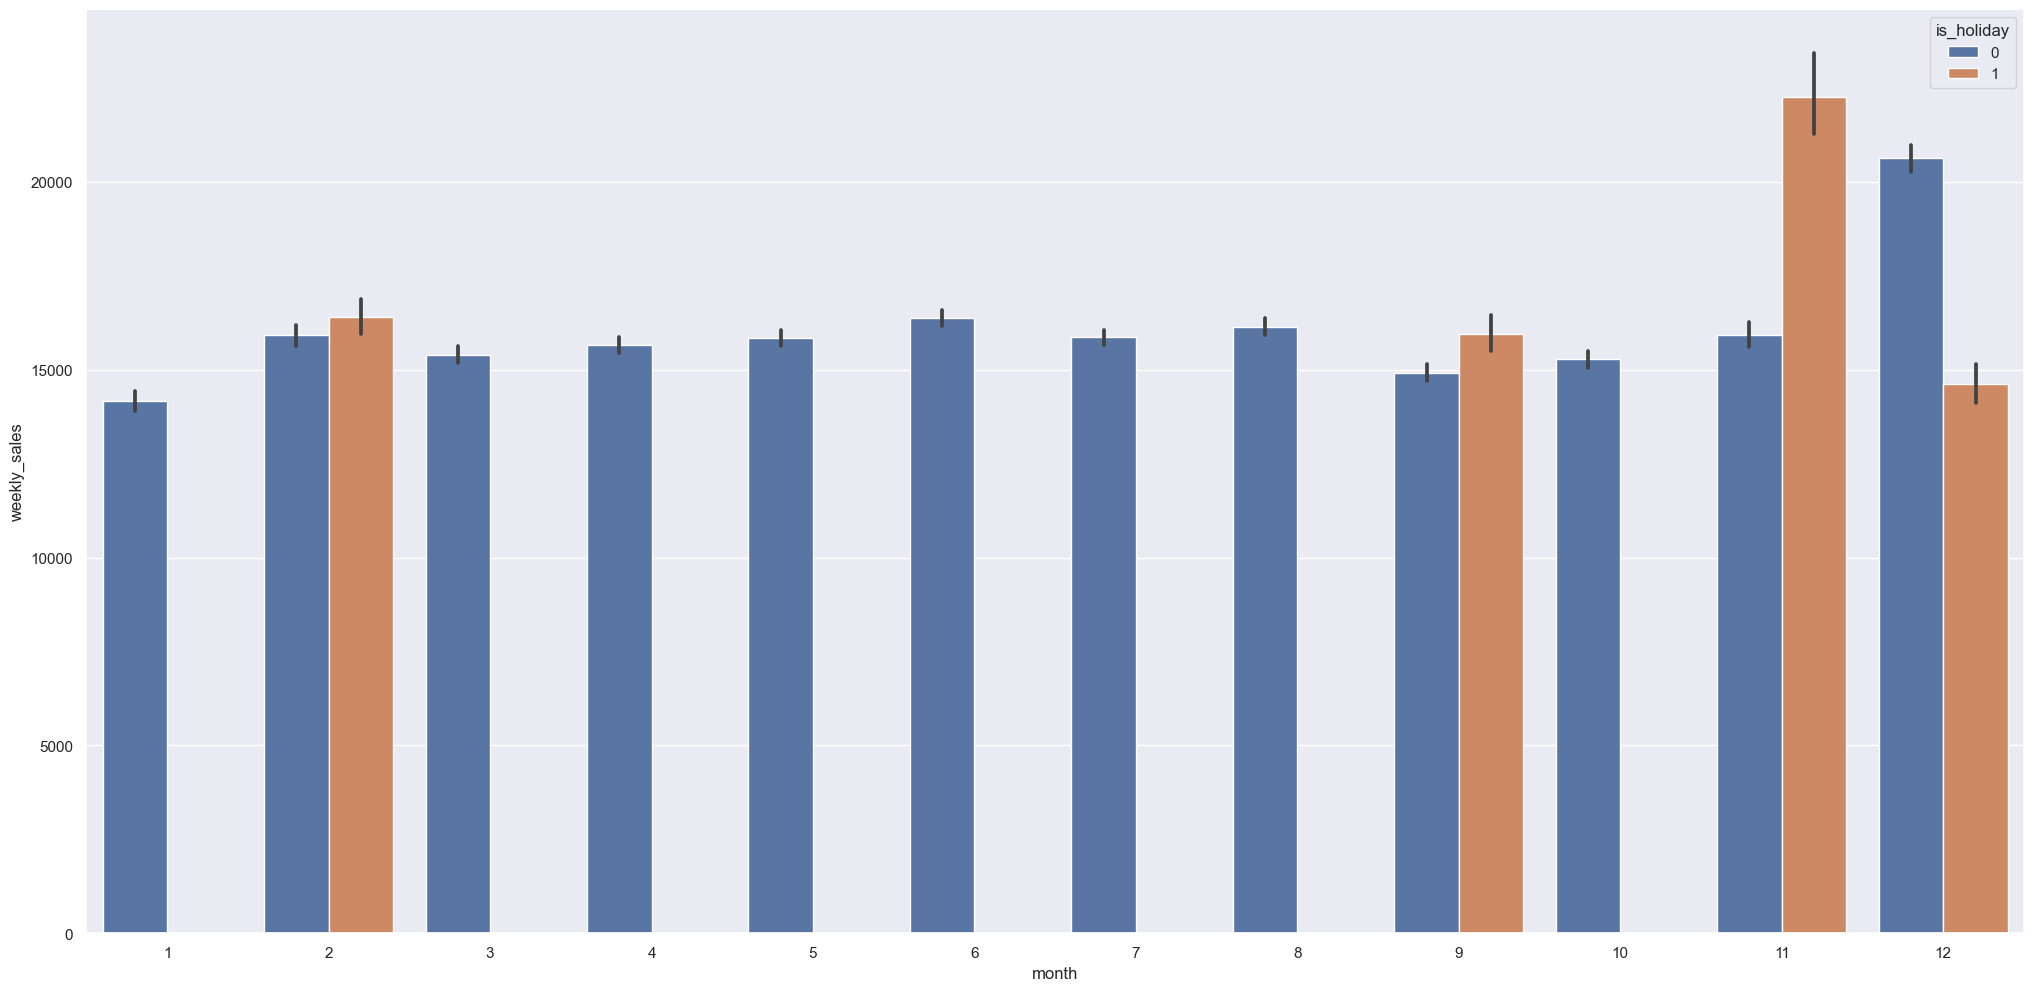

In [72]:
df4["is_holiday"] = df4["is_holiday"].replace(["Nao"],0)
df4["is_holiday"] = df4["is_holiday"].replace(["Sim"],1)

sns.barplot( x='month', y='weekly_sales', hue="is_holiday", data=df4);


##### **H8- Setor de lojas tipo A tem melhores resultados com vendas.**
Resposta: Pela ordem demonstrada no gráfico, os tipos de lojas com melhores resultados são: A, B, C. Inclusive ao longo dos anos entre 2010 a 2012, a loja de tipo "A" manteve vendas maiores. 

In [73]:
pd.crosstab(df4["type"], df4["year"] ).apply( lambda x: x / x.count(), axis=1 ).round(2)


year,2010,2011,2012
type,,,
A,23978.33,26083.67,21304.00
B,18148.33,19735.00,16168.67
C,4636.33,5156.00,4365.33


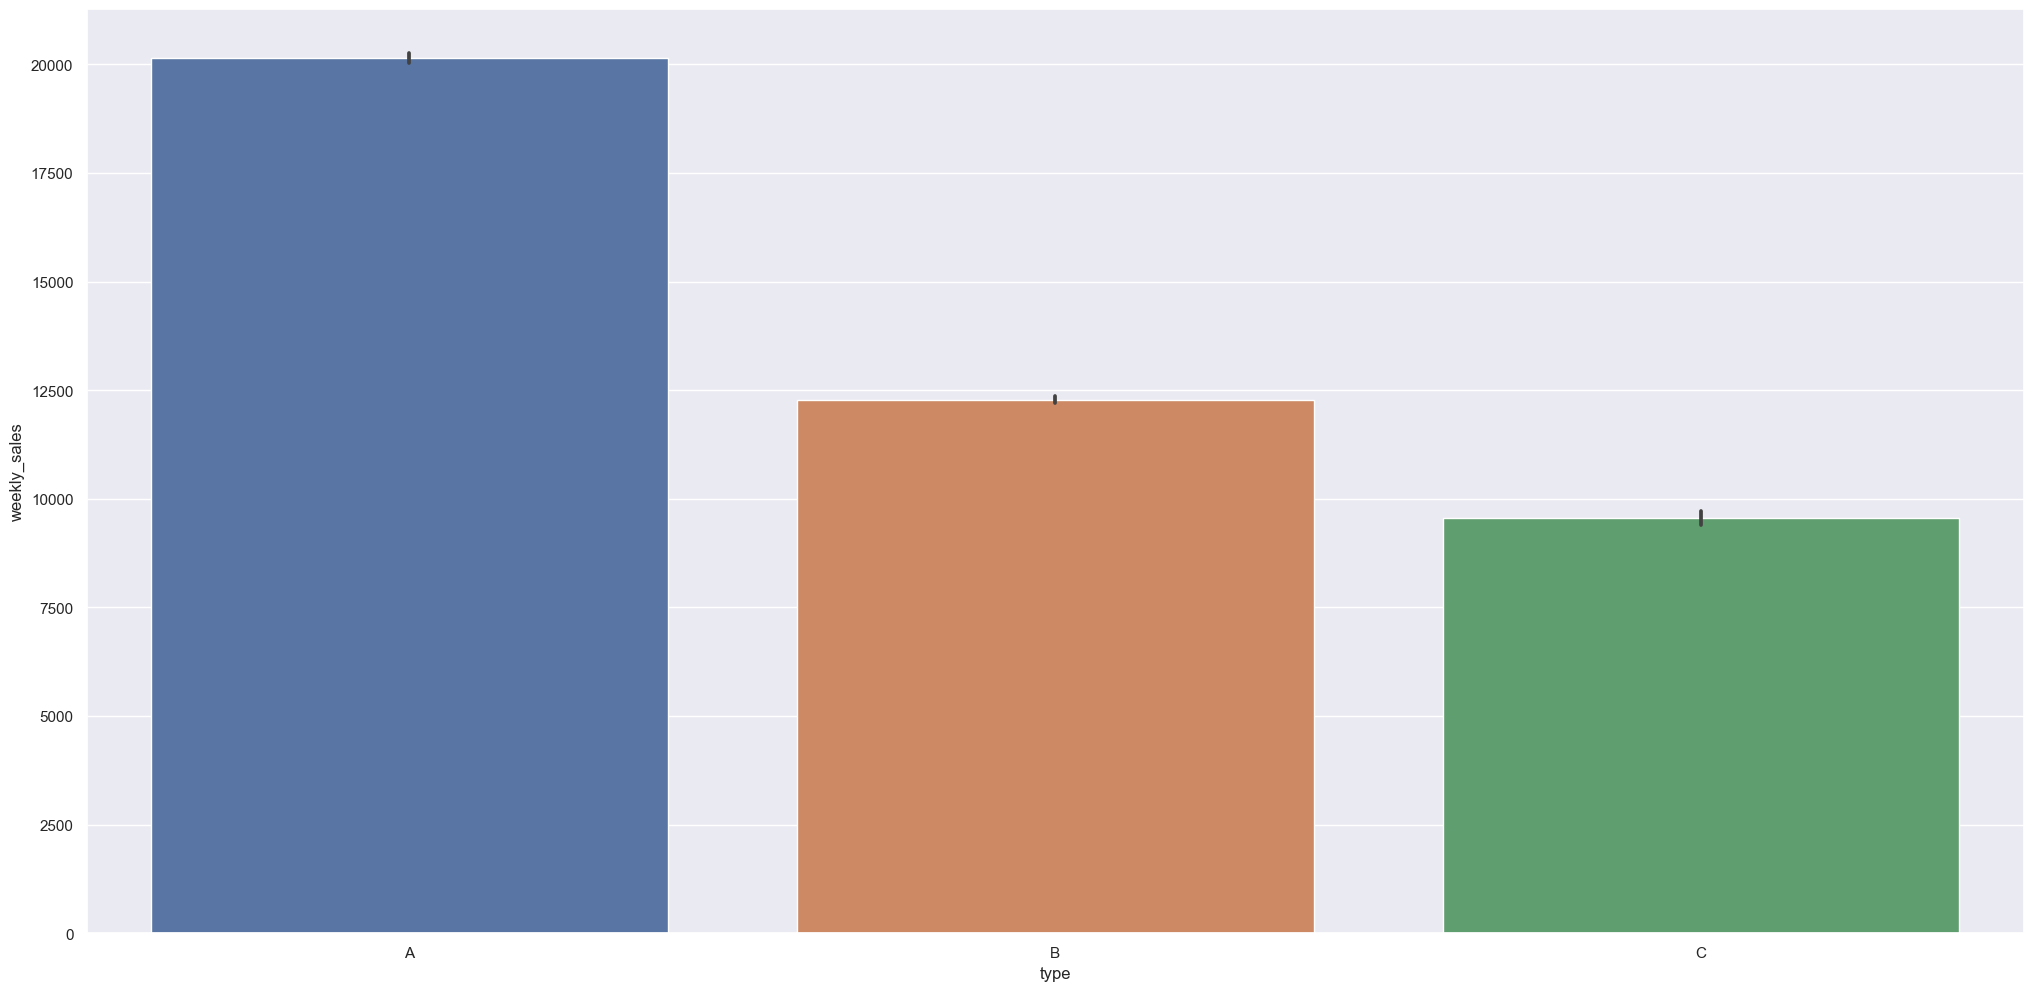

In [74]:
df4[["type","weekly_sales"]].groupby("type").sum().reset_index()
sns.barplot(x="type",y="weekly_sales",data=df4);

## **4.3 Analise Multivariada**

**descrever a associação entre mais que duas variáveis**

### **4.3.1 Numerical Attributes**

In [75]:
df1_num.head()

,store,dept,weekly_sales,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,size
0,1,1,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
1,1,2,50605.27,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
2,1,3,13740.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
3,1,4,39954.04,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
4,1,5,32229.38,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315


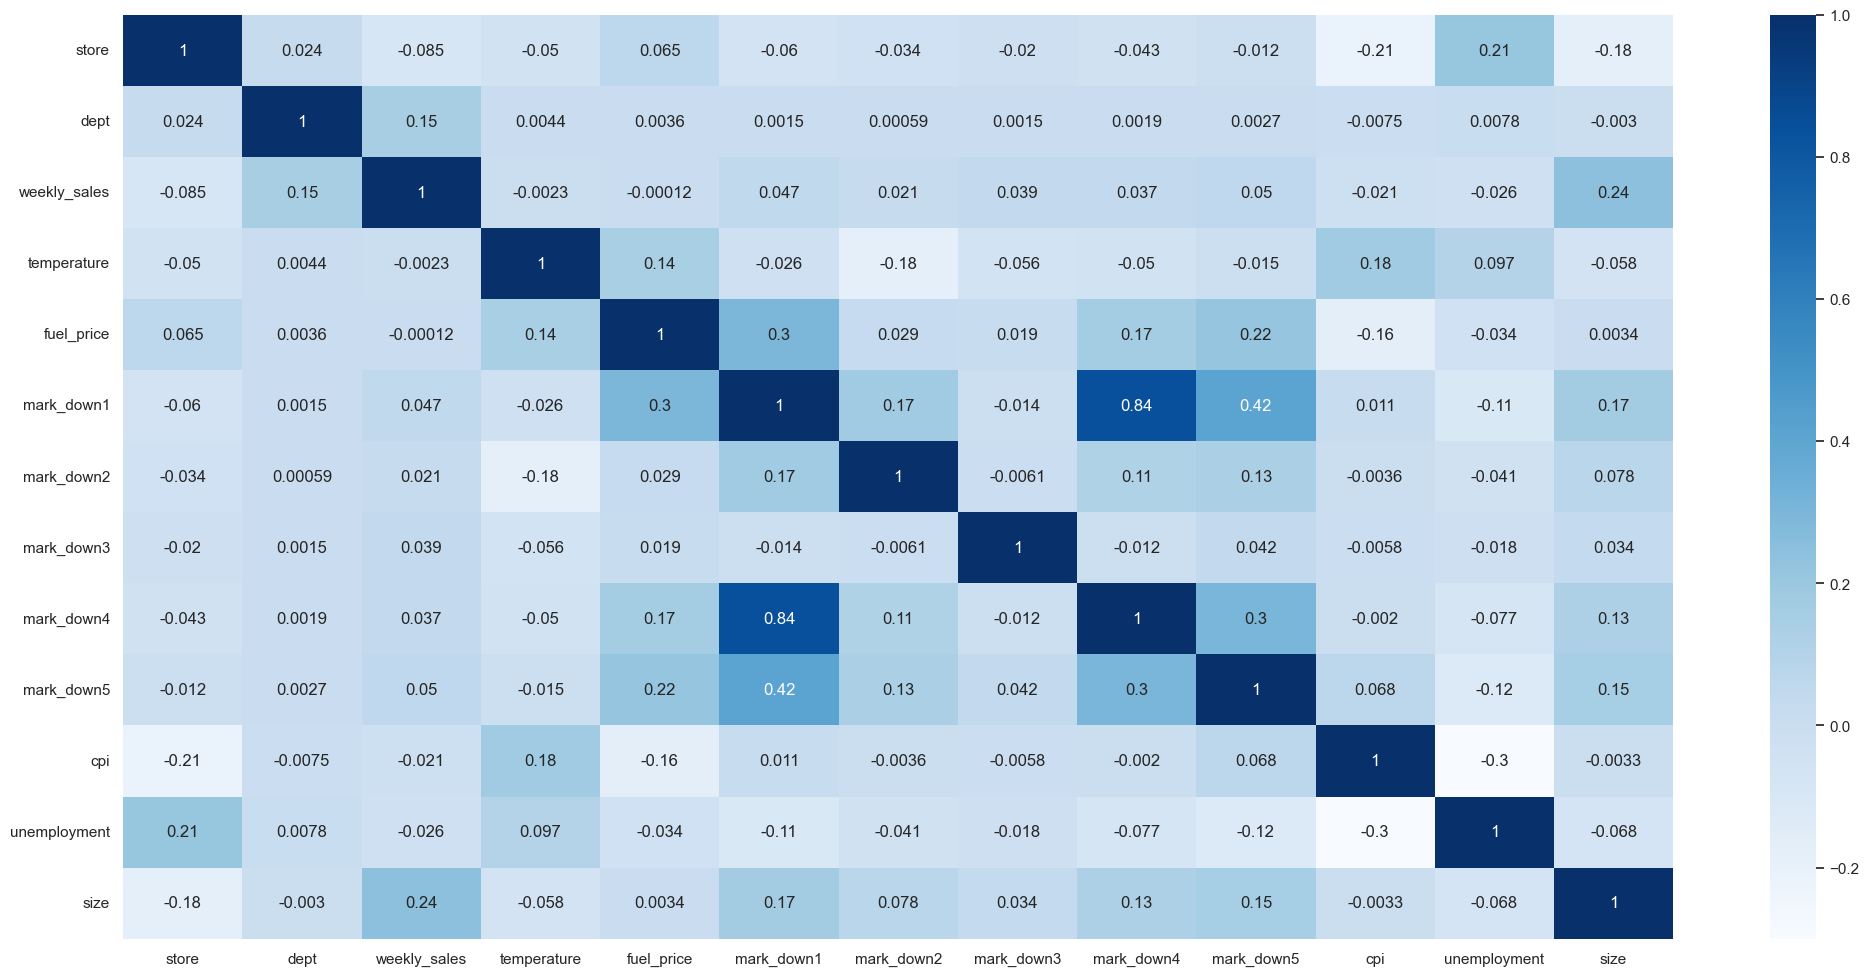

In [76]:
correlation=df1_num.corr(method="pearson")
sns.heatmap(correlation, annot=True, cmap="Blues");

### **4.3.2 Categorical Attributes**

In [77]:
df1_cat.head()

,is_holiday,type
0,Nao,A
1,Nao,A
2,Nao,A
3,Nao,A
4,Nao,A


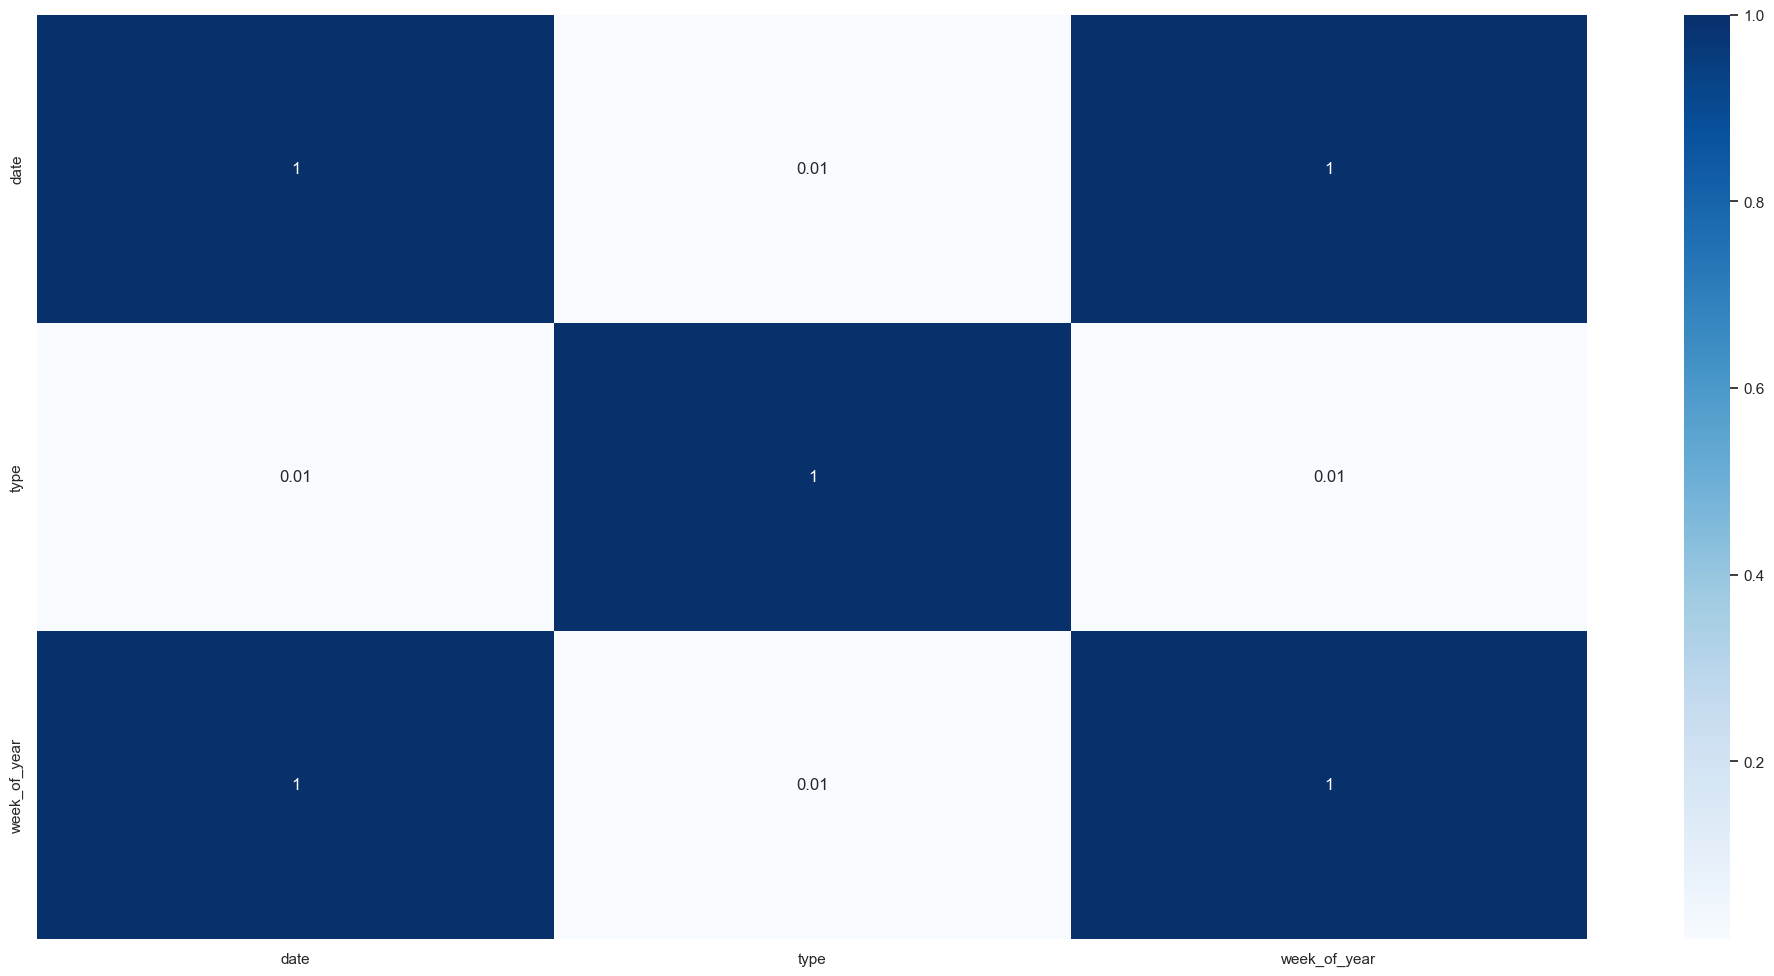

In [78]:
a = df4.select_dtypes(exclude=['float64','int64'])
rows= []

for var1 in a:
  col = []
  for var2 in a :
    
    # Cramer's V test
    cramers =cramer_v(a[var1], a[var2]) 
    # Keeping of the rounded value of the Cramer's V  
    col.append(round(cramers,2)) 
    
  rows.append(col)
  
cramers_results = np.array(rows)
dfcv = pd.DataFrame(cramers_results, columns = a.columns, index =a.columns)
sns.heatmap(dfcv, cmap='Blues', annot=True);

# **5.0 Data Preparation**

In [79]:
df5=df4.copy()

In [80]:
df5["is_holiday"] = df5["is_holiday"].replace(["Nao"],0)
df5["is_holiday"] = df5["is_holiday"].replace(["Sim"],1)

In [81]:
df5["type"] = df5["type"].replace(['A', 'B', 'C'],[1, 2, 3])


**Split into Train and Test**

In [82]:
df5[["store", "date"]].groupby("store").min().reset_index()

,store,date
0,1,2010-02-05
1,2,2010-02-05
2,3,2010-02-05
3,4,2010-02-05
4,5,2010-02-05
5,6,2010-02-05
6,7,2010-02-05
7,8,2010-02-05
8,9,2010-02-05
9,10,2010-02-05


In [83]:
df5[["store", "date"]].groupby("store").max().reset_index()

,store,date
0,1,2012-10-26
1,2,2012-10-26
2,3,2012-10-26
3,4,2012-10-26
4,5,2012-10-26
5,6,2012-10-26
6,7,2012-10-26
7,8,2012-10-26
8,9,2012-10-26
9,10,2012-10-26


In [84]:
df5[["store", "date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days=7)

Timestamp('2012-10-19 00:00:00')

In [85]:
#split

cols_drop = ["week_of_year", "day", "month", "year" ]
df5 = df5.drop( cols_drop, axis=1 )

# training dataset
x_train = df5[df5["date"] < "2012-09-14"]
y_train = x_train["weekly_sales"]

# validação dataset
x_val = df5[df5["date"] >= "2012-09-14"]
y_val = x_val["weekly_sales"]

print( 'Treino Min Date: {}'.format( x_train["date"].min() ) )
print( 'Treino Max Date: {}'.format( x_train["date"].max() ) )

print( '\nValidação Min Date: {}'.format( x_train["date"].min() ) )
print( 'Validação Max Date: {}'.format( x_train["date"].max() ) )


Treino Min Date: 2010-02-05 00:00:00
Treino Max Date: 2012-09-07 00:00:00

Validação Min Date: 2010-02-05 00:00:00
Validação Max Date: 2012-09-07 00:00:00


In [86]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)


(((398089, 16), (398089,)), ((20638, 16), (20638,)))

In [87]:
x_train.sample()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
259175,27,1,2010-10-01,26454.25,0,21.216667,2.84,0.0,0.0,0.0,0.0,0.0,136.629757,8.021,1,204184


## **5.1 Plot Váriaveis**

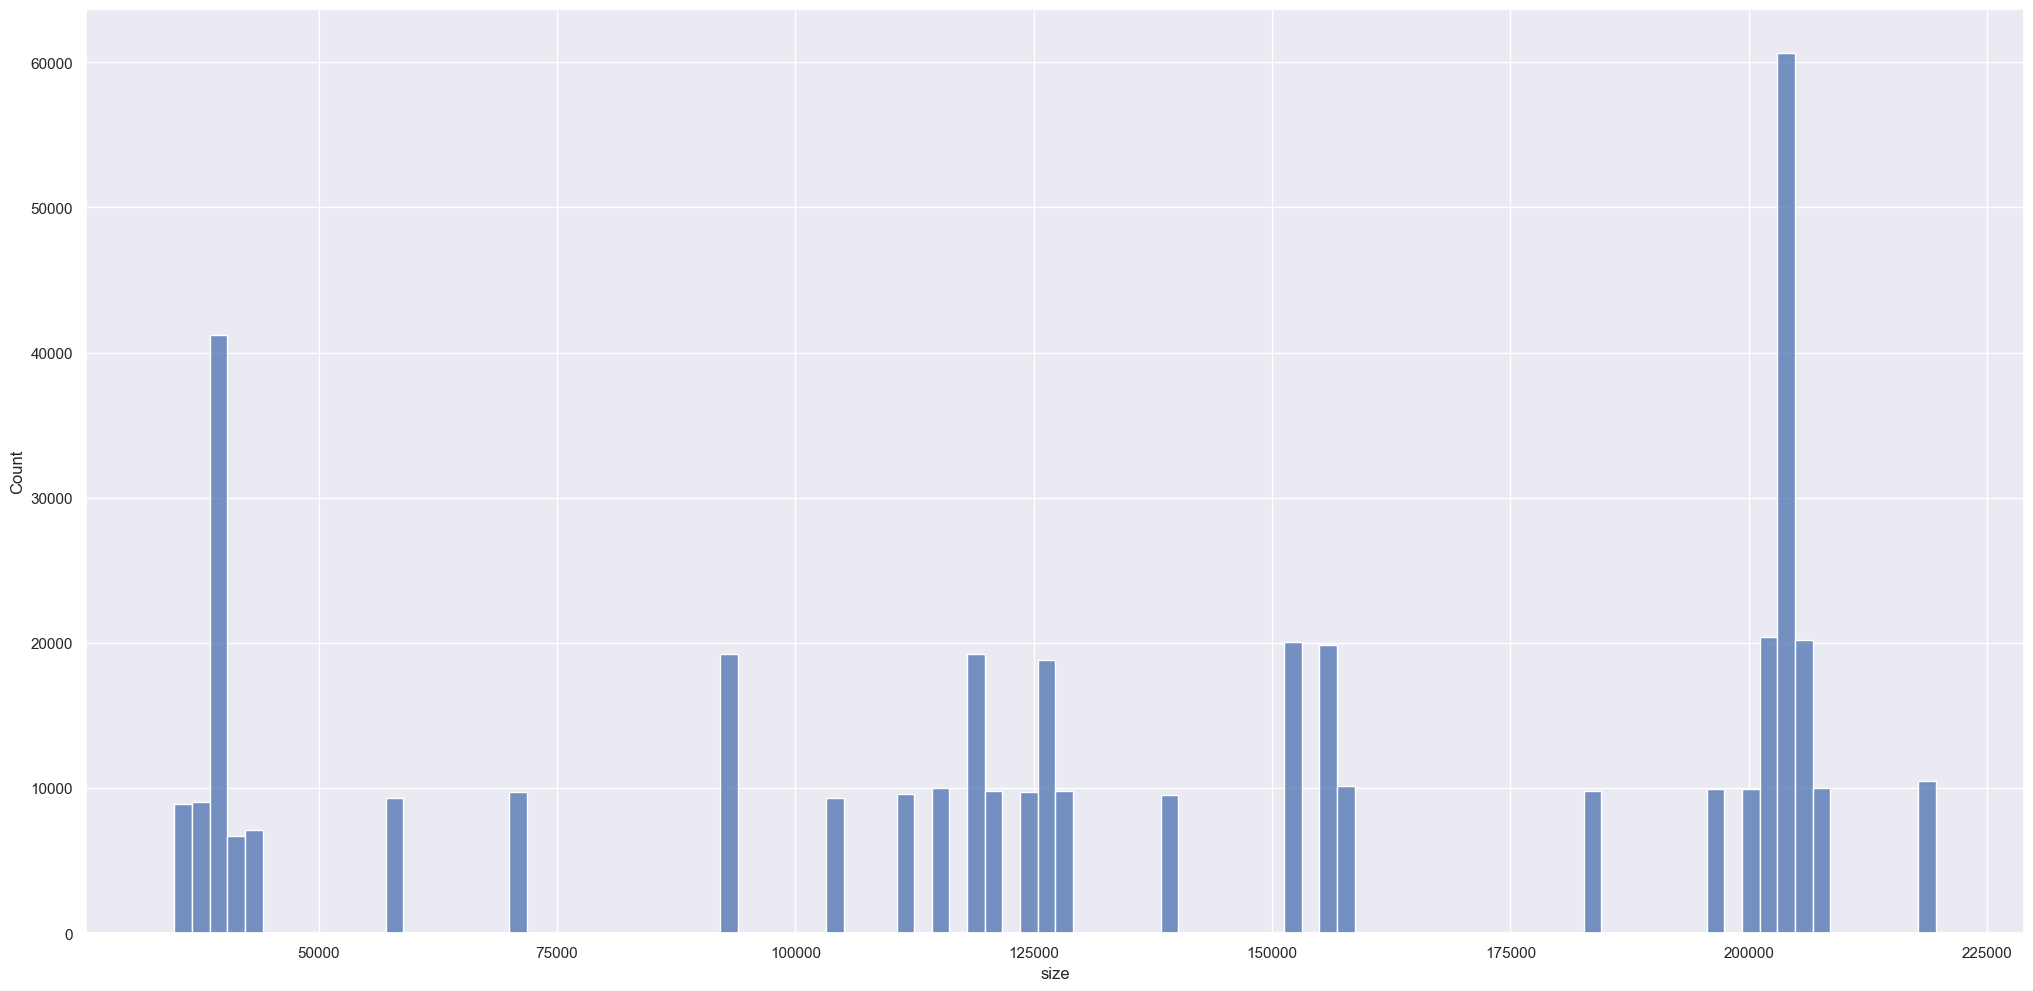

In [88]:
sns.histplot(df5["size"],bins=100);

## **5.2 Standarization**
técnica para transformar as variáveis na mesma ordem de grandeza

Não foi feito nesse ciclo

## **5.3 Rescaling**

RobustScaler - quando houver muitos outlier

MinMaxScaler - Quando não houver outliers

log - quando a distribuição for parecida com uma Poasson

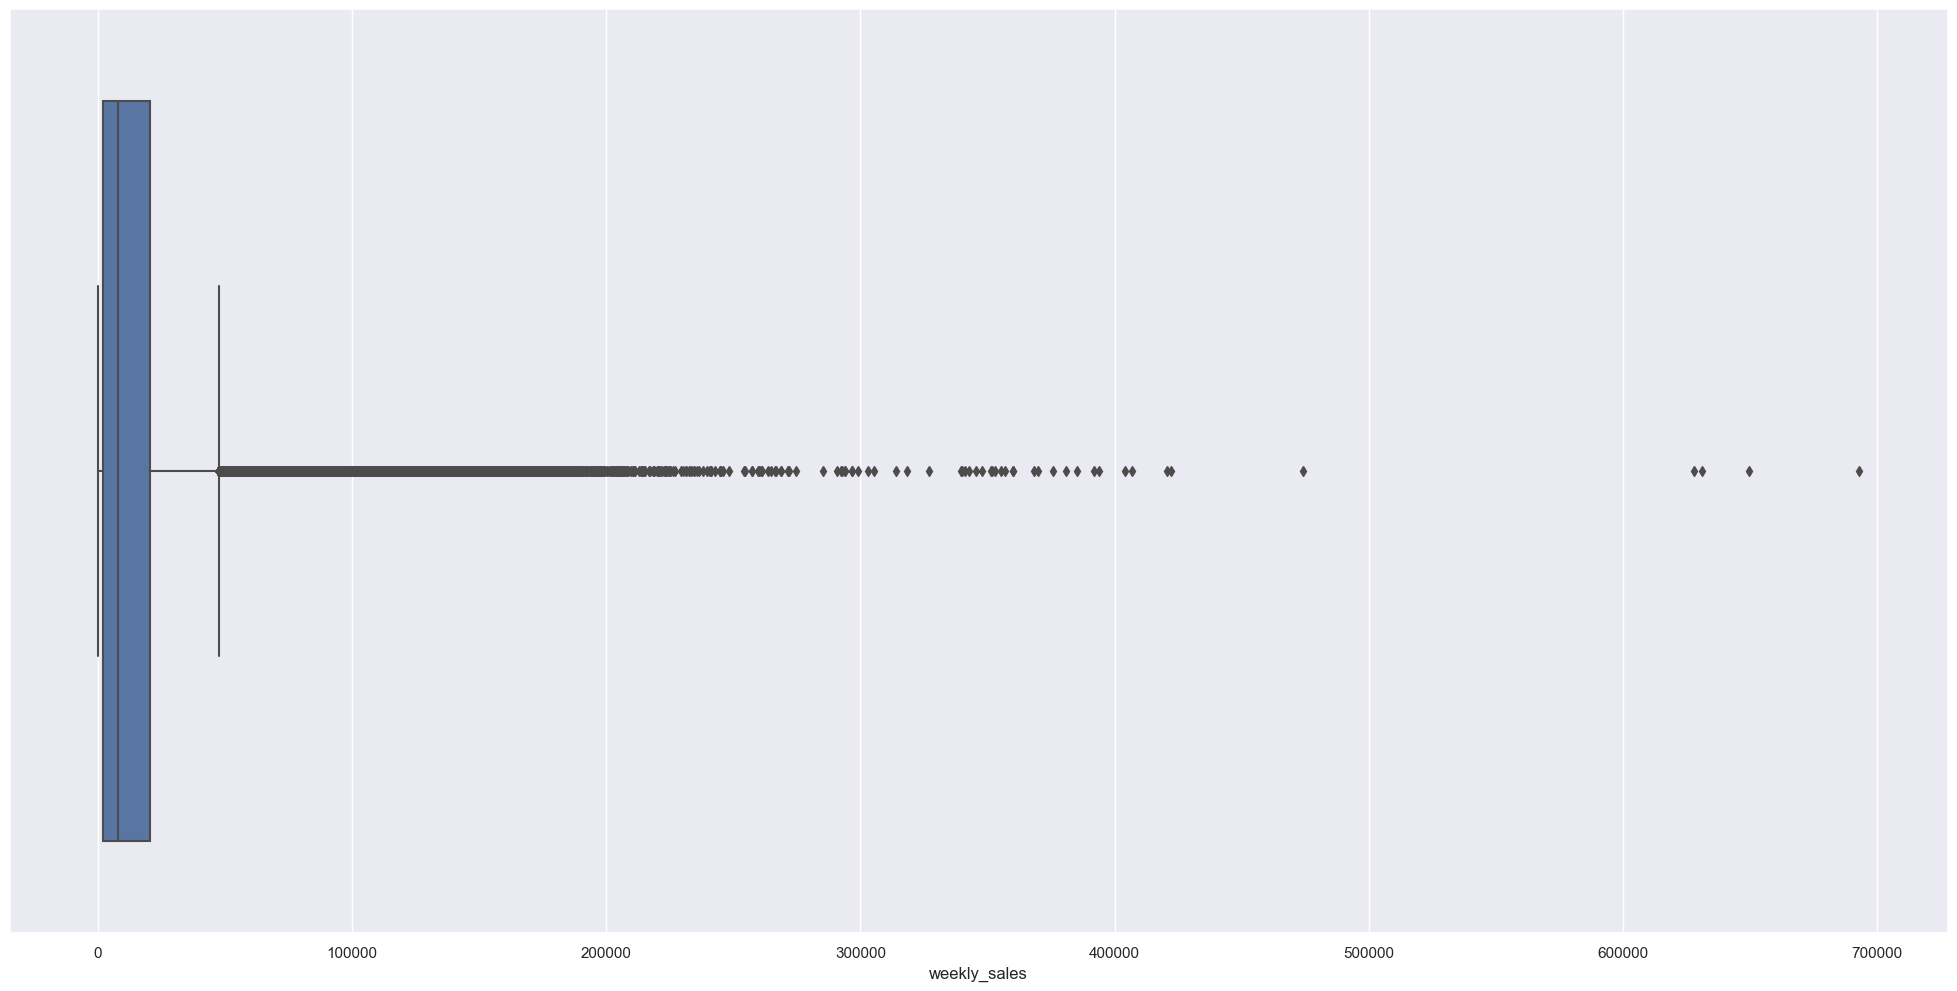

In [89]:
sns.boxplot(x="weekly_sales", data=df5);

In [90]:
df5.sample()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
276758,28,18,2012-09-28,6798.27,0,27.344444,3.966,5977.78,7.91,2.16,2458.5,6671.45,131.043,10.926,1,206302


In [91]:
rs=RobustScaler()
mms=MinMaxScaler()
encoder=LabelEncoder() 

#store
#df5["store"] = mms.fit_transform(df5[["store"]].values)
#pickle.dump( mms, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/store_scaler.pkl', 'wb') )

#dept
#df5["dept"] = mms.fit_transform(df5[["dept"]].values)
#pickle.dump( mms, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/dept_scaler.pkl', 'wb') )

#temperature
#df5["temperature"] = mms.fit_transform(df5[["temperature"]].values)
#pickle.dump( mms, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/temperature_scaler.pkl', 'wb') )

#fuel_price
df5["fuel_price"] = mms.fit_transform(df5[["fuel_price"]].values)
pickle.dump( mms, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/fuel_price_scaler.pkl', 'wb') )

#mark_down1
df5["mark_down1"] = rs.fit_transform(df5[["mark_down1"]].values)
pickle.dump( rs, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/mark_down1_scaler.pkl', 'wb') )

#mark_down2
df5["mark_down2"] = rs.fit_transform(df5[["mark_down2"]].values)
pickle.dump( rs, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/mark_down2_scaler.pkl', 'wb') )

#mark_down3
df5["mark_down3"] = rs.fit_transform(df5[["mark_down3"]].values)
pickle.dump( rs, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/mark_down3_scaler.pkl', 'wb') )

#mark_down4
df5["mark_down4"] = rs.fit_transform(df5[["mark_down4"]].values)
pickle.dump( rs, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/mark_down4_scaler.pkl', 'wb') )

#mark_down5
df5["mark_down5"] = rs.fit_transform(df5[["mark_down5"]].values)
pickle.dump( rs, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/mark_down5_scaler.pkl', 'wb') )

#cpi
df5["cpi"] = mms.fit_transform(df5[["cpi"]].values)
pickle.dump( mms, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/cpi_scaler.pkl', 'wb') )

#unemployment
df5["unemployment"] = rs.fit_transform(df5[["unemployment"]].values)
pickle.dump( rs, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/unemployment_scaler.pkl', 'wb') )

#size
df5["size"] = mms.fit_transform(df5[["size"]].values)
pickle.dump( mms, open( '/Users/raquelrocha/Documents/ProcessosSeletivos/Ioasys/pkl/size_scaler.pkl', 'wb') )

#year
#df5["year"] = mms.fit_transform(df5[["year"]].values)

#month
#df5["month"] = mms.fit_transform(df5[["month"]].values)

#day
#df5["day"] = mms.fit_transform(df5[["day"]].values)

#week_of_year
#df5["week_of_year"] = mms.fit_transform(df5[["week_of_year"]].values)

#weekly_sales
#df5["weekly_sales"] = mms.fit_transform(df5[["weekly_sales"]].values)


## **5.4 Encoder**
técnica para mudar o tipo de variável de categórica para númerica, respeitando no máximo sua natureza

TIPOS DE ENCODING

Label Encoding (mapeia se tem ou não tem Ex: 0 e 1)

One Hot Encoding (identifica um estado Ex:0 e 1), se houver muitos não é indicado P.S. quando tem muitos(acima de 6/7) níveis em sua variável categórica, se usar uma hot encoding irá criar muitas dimensões no dataset que a amostra de dimensionalidade irá acabar com o modelo

Target Encoding (calcula a média, de quantas pessoas tem a licença e divide pelo total de pessoas daquele grupo)

Weighted Target Encoding (da peso manual para a variável Ex: quanto maior o peso mais próximo fica da média, e quanto menor o peso fica mais distante da média)

Order Encoding (mapeia a ordem ex: 2 anos seria 2x de 1 ano, e 3 anos seria 3x de 1 ano e assim vai) One Hot Encoding (identifica um estado Ex: velho e novo)

Frequency Encoding (EX: conta a frequência, quantos carros que são velhos, quantos carros que são novos)

P.S. função Get_dummys (pandas), é igual ao Hot Encoding

In [92]:
df1_cat.sample()

,is_holiday,type
89881,Nao,B


**As variáveis categóricas tiveram sua natureza alterada em passo anterior, por isso não foi necessário realizar esse passo**


### **5.4.0 Response Variable Transformation**

In [93]:
#df5["weekly_sales"] = np.log1p( df5["weekly_sales"])

In [94]:
#sns.distplot (df5["weekly_sales"])

### **5.4.1 Validation Preparation**

In [95]:
#store
#x_val.loc[:,"store"] = mms.fit_transform(x_val[["store"]].values)

#dept
#x_val.loc[:,"dept"] = mms.fit_transform(x_val[["dept"]].values)

#temperature
#x_val.loc[:,"temperature"] = mms.fit_transform(x_val[["temperature"]].values)

#fuel_price
x_val.loc[:,"fuel_price"] = mms.fit_transform(x_val[["fuel_price"]].values)

#mark_down1
x_val.loc[:,"mark_down1"] = rs.fit_transform(x_val[["mark_down1"]].values)

#mark_down2
x_val.loc[:,"mark_down2"] = rs.fit_transform(x_val[["mark_down2"]].values)

#mark_down3
x_val.loc[:,"mark_down3"] = rs.fit_transform(x_val[["mark_down3"]].values)

#mark_down4
x_val.loc[:,"mark_down4"] = rs.fit_transform(x_val[["mark_down4"]].values)

#mark_down5
x_val.loc[:,"mark_down5"] = rs.fit_transform(x_val[["mark_down5"]].values)

#cpi
x_val.loc[:,"cpi"] = mms.fit_transform(x_val[["cpi"]].values)

#unemployment
x_val.loc[:,"unemployment"] = rs.fit_transform(x_val[["unemployment"]].values)

#size
x_val.loc[:,"size"] = mms.fit_transform(x_val[["size"]].values)


In [96]:
# is_holiday e type
x_val.loc[:, "is_holiday"] = df5['is_holiday']
x_val.loc[:, "type"] = df5['type']


# **6.0 Feature Seletion**

In [97]:
df6=df5.copy()

## **6.1 Boruta Selection**

In [94]:
x_train.head()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,0,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315
1,1,2,2010-02-05,50605.27,0,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315
2,1,3,2010-02-05,13740.12,0,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315
3,1,4,2010-02-05,39954.04,0,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315
4,1,5,2010-02-05,32229.38,0,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315


In [ ]:
# implementar o Boruta
# usar a classe BorutaPy, rf = Random Forest verbose vai mostrando a contrução da árvore, random state faz com que o boruta parta do mesmo início(pq o boruta faz de forma aleatorio, então assim fazemos q parta do mesmo inico, pode ser qualquer número)

# training and test dataset for Boruta
x_train_n = x_train.drop(["date", "weekly_sales"], axis=1).values
y_train_n = y_train.values.ravel() #Ravel põe tudo dentro de um vetor

#definindo Random Forest Regressor
rf = RandomForestRegressor(n_jobs=-1)#n_jobs=-1 faz com que crie as arvoes em paralelo 

#definindo Boruta
boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42).fit(x_train_n, y_train_n)


In [ ]:
# variáveis que o boruta rankeou/selecionou como mais importantes
cols_selected = boruta.support_.tolist()

# x_train_n é um array (vetor de numeros) p.s fs = feature selection
x_train_fs = x_train.drop(["date", "sales"], axis=1)

cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# colunas que o boruta não rankeou/selecionou
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

## **6.2 Features Importance Selection**

In [ ]:
#model definition
forest = en.ExtraTreesClassifier(n_estimators = 40, random_state = 0, n_jobs = -1)

#data preparation
x_train_n = df5.drop (["date", "weekly_sales"], axis=1)
y_train_n = y_train.values
forest.fit (x_train_n, y_train_n)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i , 'importance': j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks( range(x_train_n.shape[1]), indices)
plt.xlim( [-1, x_train_n.shape[1]])
plt.show()

# **7.0 Machine Learning**

In [98]:
df6.columns

Index(['store', 'dept', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4',
       'mark_down5', 'cpi', 'unemployment', 'type', 'size'],
      dtype='object')

In [99]:
# Feature Importance:
cols_selected = ['store', 'dept', 'mark_down1', 'mark_down2', 'mark_down3',
                 'mark_down4', 'mark_down5', 'cpi', 'unemployment', 'type',
                 'size', 'is_holiday']


In [100]:
# Feature Importance2:
cols_selected = ['store', 'dept', 'is_holiday']

In [101]:
x_train = x_train[ cols_selected ]
x_val = x_val[ cols_selected ]
y_val = y_val.copy()

In [102]:
x_train.sample(10)

,store,dept,is_holiday
81270,9,1,0
92355,10,35,0
305116,32,56,0
193267,20,18,1
272213,28,8,0
276555,28,27,1
60883,7,33,0
116382,12,97,0
42430,5,29,1
45875,5,71,0


In [103]:
x_val.head()

,store,dept,is_holiday
9740,1,1,0
9741,1,2,0
9742,1,3,0
9743,1,4,0
9744,1,5,0


In [104]:
y_val.head()

9740    19616.22
9741    44493.61
9742    14288.22
9743    35044.06
9744    19369.52
Name: weekly_sales, dtype: float64

In [105]:
len(x_train.columns)

3

In [106]:
print(x_train.shape,y_train.shape)

(398089, 3) (398089,)


## 7.1 Average Model

In [107]:
#p.s. o mean absolute ainda não tinha no sklearn, então iremos criar

#def mean_absolute_percentage_error( y, yhat ):
#    return np.mean( np.abs( ( y - yhat ) / y )) * 100

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [108]:
# média de cada vendas das lojas
# aqui vamos criar uma copia do x_test e criarmos uma variável sales, colocaremos ela dentro de y_test, e usaremos o dataset original mas em ponto de teste.  
aux1 = x_val.copy()
aux1["weekly_sales"] = y_val.copy()

# aqui teremos a média das vendas de todas as lojas desse conjunto de dados
# Prediction
# p.s. yhat é quando tem valor estimado
aux2 = aux1[["store", "weekly_sales"]].groupby("store").mean().reset_index().rename(columns={"weekly_sales":"predictions"})
aux1 = pd.merge(aux1, aux2, how="left", on="store")
yhat_baseline = aux1["predictions"]

# Performance do modelo
# P.S. lembrar quando estavamos fazendo as transformações das variáves transformamos as variáveis resposta usando o logaritmo LOG, 5.3.2, então devemos voltar para os valores originais, então devemos aplicar o exponencial para voltar esses valores para orignal
baseline_result = ml_error("Average Model", y_val, yhat_baseline)

baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,13706.385637,2.386154e+15,20559.686148


In [109]:
aux1.sample(4)

,store,dept,is_holiday,weekly_sales,predictions
10583,23,9,0,47687.19,19478.234049
10918,23,92,0,77649.19,19478.234049
16832,36,74,0,455.05,6484.278447
10462,22,25,0,10655.60,14470.905157


## **7.2 Linear Regression Regularized Model - Lasso**

In [110]:
#model definition
lrr_model = Lasso(alpha=0.01, random_state=42)

#model_fit
lrr_model.fit(x_train, y_train)

# predict
yhat_lrr=lrr_model.predict(x_val)

# performance
lrr_model_result = ml_error("Linear Regression - Lasso", y_val, yhat_lrr)
lrr_model_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,14702.97932,2.793257e+15,21206.198446


In [111]:
lrr_df = pd.DataFrame({'Actual': y_val, 'Predicted': yhat_lrr})
lrr_df.head()

,Actual,Predicted
9740,19616.22,14518.970405
9741,44493.61,14630.797205
9742,14288.22,14742.624005
9743,35044.06,14854.450805
9744,19369.52,14966.277605


In [112]:
#testando o mape
mean_absolute_percentage_error(y_val, yhat_lrr)

2793257191948130.5

In [113]:
#aqui mostra o porque o mape está retornando esses valores
y_val.min()

0.0

## **7.3 Random Forest Regressor**

In [114]:
# n_estimators = quantidade de árvores, n_jobs = roda em paralelo, random_state = garante o mesmo treino and validação em caso de diferentes execuções  

# model
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train) 

# prediction
yhat_rf_model = rf_model.predict(x_val)

# performance
rf_model_result = ml_error("Random Forest Regressor", y_val, yhat_rf_model)
rf_model_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2162.671401,9.290530e+11,4127.160944


In [115]:
rf_df = pd.DataFrame({'Actual': y_val, 'Predicted': yhat_rf_model})
rf_df.head()

,Actual,Predicted
9740,19616.22,22356.808656
9741,44493.61,46302.575212
9742,14288.22,13426.894102
9743,35044.06,36871.856688
9744,19369.52,23412.926220


## **7.4 Knn Regressor**

In [116]:
#model definition
knn_model = KNeighborsRegressor(n_neighbors=7)

#model_fit
knn_model.fit(x_train, y_train)

# predict
yhat_knn=knn_model.predict(x_val)

# performance
knn_model_result = ml_error("KNN Regression", y_val, yhat_knn)
knn_model_result

,Model Name,MAE,MAPE,RMSE
0,KNN Regression,3119.111926,1.153130e+12,6204.232855


In [117]:
knn_df = pd.DataFrame({'Actual': y_val, 'Predicted': yhat_knn})
knn_df.head()

,Actual,Predicted
9740,19616.22,22500.020000
9741,44493.61,45532.068571
9742,14288.22,9947.622857
9743,35044.06,35047.767143
9744,19369.52,22105.870000


## **7.5 XGBoost Regressor**

In [118]:
# model
xgb_model = xgb.XGBRegressor( objective="reg:squarederror",#função objetiva
                              n_estimators=100, 
                              eta=0.01, # quantas passadas ele usa para azer o aprendizado
                              max_depth=10, # máxima ramificação que a árvore pode chegar
                              subsample=0.7, # quantas amostrars e porcentagens de todas as variáveis que tenho para fazer a amostragem para mostrar as mais interessantes
                              colsample_bytree=0.9).fit(x_train, y_train) # fazer o sample por cada uma das árvores
# prediction
yhat_xgb = xgb_model.predict(x_val)

# performance
xgb_model_result = ml_error("XGBoost Regressor", y_val, yhat_xgb)
xgb_model_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,7306.114779,4.739220e+14,14017.014645


In [119]:
xgb_df = pd.DataFrame({'Actual': y_val, 'Predicted': yhat_xgb})
xgb_df.head()

,Actual,Predicted
9740,19616.22,13688.499023
9741,44493.61,26982.365234
9742,14288.22,8510.635742
9743,35044.06,17432.828125
9744,19369.52,15791.964844


## **Comparação da performance dos modelos**

In [120]:
modelling_result = pd.concat([baseline_result, lrr_model_result, rf_model_result, knn_model_result ,xgb_model_result])
modelling_result.sort_values("RMSE") # ordenar pelo menos rmse para olhar o modelo que tem o menor erro


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2162.671401,9.290530e+11,4127.160944
0,KNN Regression,3119.111926,1.153130e+12,6204.232855
0,XGBoost Regressor,7306.114779,4.739220e+14,14017.014645
0,Average Model,13706.385637,2.386154e+15,20559.686148
0,Linear Regression - Lasso,14702.979320,2.793257e+15,21206.198446


## **7.6 Cross Validation**

In [126]:

def cross_validation(x_train, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print("\nKFold Number:{}".format(k))

        ## start and end date for validation
        #validation_start_date = x_train["date"].max() - datetime.timedelta(days=k*7) # ao alterar o número 1 e 0 abaixo, vai mudando o tempo do k=1 k=2 k=3 etapas d ciclo do cross validation, p.s. colocamos a função usando o k no lugar do número
        #validation_end_date = x_train["date"].max() - datetime.timedelta(days=(k-1)*7)

        ## filtering dataset, filtrar para tornar os outros dados como dados de treino
        ## aqui é o primeiro ciclo
        #training = x_train[x_train["date"] < validation_start_date]

        # aqui é o segundo ciclo
        #validation = x_train[(x_train["date"] >= validation_start_date) & (x_train["date"] <= validation_end_date)]

        ## training and validation dataset
        ## Training
        #x_train = training.drop(["date","weekly_sales"], axis=1)
        #y_train = training["weekly_sales"]
        x_train
        y_train
        
        ## Validation
        #x_val = validation.drop(["date","weekly_sales"], axis=1)
        #y_val = validation["weekly_sales"]
        x_val
        y_val
        
        # model (treinar o modelo)
        m = model.fit(x_train, y_train)
        # prediction
        yhat = m.predict(x_val)                        
        # performance   
        m_result = ml_error(model_name, y_val, yhat)
        #print(lr_result)

        # Store performance of each kfold iteration
        mae_list.append(m_result["MAE"])
        mape_list.append(m_result["MAPE"])
        rmse_list.append(m_result["RMSE"])

    #aqui vamos calcular a média e mostrar um DataFrame pronto
    # cv = cross validation
    # métrica real de performance
    return pd.DataFrame ({"Model Name": model_name,
                      "MAE CV": np.round(np.mean(mae_list),2).astype(str)+ ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                      "MAPE CV": np.round(np.mean(mape_list),2).astype(str)+ ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                      "RMSE CV": np.round(np.mean(rmse_list),2).astype(str)+ ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index =[0])

In [128]:
#baseline_result_cv = cross_validation(x_train, 5, "Lasso", lrr_model, verbose=True)

lrr_result_cv = cross_validation(x_train, 5, "Lasso", lrr_model, verbose=True)

rf_result_cv = cross_validation(x_train, 5, "Random Forest Regressor", rf_model, verbose=True)

knn_result_cv = cross_validation(x_train, 5, "KNN", knn_model, verbose=True)

xgb_result_cv = cross_validation(x_train, 5, "XgBoost", xgb_model, verbose=True)



KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


### **7.6.1 Compare Model's Performance - Cross Validation**

In [129]:
resultado_cross = pd.concat([rf_result_cv, knn_result_cv, xgb_result_cv, lrr_result_cv])
resultado_cross


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,2162.67 +/- 0.0,929052976821.75 +/- 0.0,4127.16 +/- 0.0
0,KNN,3119.11 +/- 0.0,1153130495893.44 +/- 0.0,6204.23 +/- 0.0
0,XgBoost,7306.11 +/- 0.0,473922009977040.94 +/- 0.0,14017.01 +/- 0.0
0,Lasso,14702.98 +/- 0.0,2793257191948130.5 +/- 0.0,21206.2 +/- 0.0


# **8.0 Hiperparameter Fine Tunning**

### **8.1.1 Random Search**

In [130]:
# parâmetros
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

               'max_features': max_features,

               'max_depth': max_depth,

               'min_samples_split': min_samples_split,

               'min_samples_leaf': min_samples_leaf,

               'bootstrap': bootstrap}


In [131]:
rf = RandomForestRegressor()

rf_random_tunning = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random_tunning.fit(x_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/raquelrocha/opt/anaconda3/envs/ioasys/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/raquelrocha/opt/anaconda3/envs/ioasys/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/raquelrocha/opt/anaconda3/envs/ioasys/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=42, verbose=2)

In [132]:
print ('Random grid: ', random_grid, '\n')

# print mehores parâmetros
print ('Best Parameters: ', rf_random_tunning.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 120, 'bootstrap': True}  



### **8.1.2 Final Model**

In [133]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [134]:
# modelo final
rf_model_tuned = RandomForestRegressor(n_estimators = 130, min_samples_split = 4, min_samples_leaf= 1, max_features = 1.0, max_depth= None, bootstrap=True, random_state= 42).fit(x_train, y_train) 

# prediction
yhat_rf_model_tuned = rf_model_tuned.predict(x_val)

# performance
rf_model_result_tuned = ml_error("Random Forest Regressor", y_val, yhat_rf_model_tuned)
rf_model_result_tuned


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2162.757318,9.374463e+11,4126.272448


In [135]:
rf_pred_tunning = pd.DataFrame({'Actual': y_val, 'Predicted': yhat_rf_model_tuned})
rf_pred_tunning.head()

,Actual,Predicted
9740,19616.22,22282.254630
9741,44493.61,46312.662487
9742,14288.22,13437.947332
9743,35044.06,36883.592702
9744,19369.52,23358.726323


# **9.0 Tradução e Interpretação do Erro**

In [136]:
x_val.head()

,store,dept,is_holiday
9740,1,1,0
9741,1,2,0
9742,1,3,0
9743,1,4,0
9744,1,5,0


In [137]:
df9 = pd.DataFrame({'weekly_sales': y_val, 'predicted': yhat_rf_model_tuned})

In [138]:
df9.head()

,weekly_sales,predicted
9740,19616.22,22282.254630
9741,44493.61,46312.662487
9742,14288.22,13437.947332
9743,35044.06,36883.592702
9744,19369.52,23358.726323


In [139]:
df9['store'] = x_val['store']
df9.head()

,weekly_sales,predicted,store
9740,19616.22,22282.254630,1
9741,44493.61,46312.662487,1
9742,14288.22,13437.947332,1
9743,35044.06,36883.592702,1
9744,19369.52,23358.726323,1


# **9.1 Business Performance**

In [141]:
# Sum os Predictions, para saber quanto de dinheiro irá entrar com o modelo.
df91 = df9 [["store", "predicted"]].groupby("store").sum().reset_index()

# MAE RMSE, para reportar o valor de negócio.
# Modelo do MAE
df9_aux1 = df9[["store", "weekly_sales", "predicted"]].groupby("store").apply(lambda x:mean_absolute_error(x["weekly_sales"], x["predicted"])).reset_index().rename(columns = {0:"MAE"}) # primeiro argumento são as vendas reais (sales) e segundo argumento (são as predições)

#Modelo RMSE
df9_aux2 = df9[["store", "weekly_sales", "predicted"]].groupby("store").apply(lambda x:mean_squared_error(x["weekly_sales"], x["predicted"])).reset_index().rename(columns = {0:"RMSE"}) # primeiro argumento são as vendas reais (sales) e segundo argumento (são as predições)

# Merge (Aqui reuniremos os valores MAE e RMSE)
#inner = comparar as lojas, por isso coloca store no "on"
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how="inner", on="store")
#Aqui colocaremos o MAE e o RMSE junto somas das predições por loja
df92 = pd.merge(df91, df9_aux3, how="inner", on="store")

# Scenarios
df92["pior_cenario"] = df92["predicted"] - df92["RMSE"]
df92["melhor_cenario"] = df92["predicted"] + df92["RMSE"]

# order columns, ver nessa ordem os dados
df92 = df92[["store", "predicted", "pior_cenario", "melhor_cenario", "MAE", "RMSE"]]


In [142]:
df9_aux1.head()


,store,MAE
0,1,2511.658506
1,2,2980.987861
2,3,1354.125250
3,4,3290.248357
4,5,696.466286


In [143]:
df92.head()


,store,predicted,pior_cenario,melhor_cenario,MAE,RMSE
0,1,1.088715e+07,-7.544500e+06,2.931879e+07,2511.658506,1.843165e+07
1,2,1.344459e+07,-1.412279e+07,4.101197e+07,2980.987861,2.756738e+07
2,3,2.803138e+06,-8.610250e+06,1.421653e+07,1354.125250,1.141339e+07
3,4,1.458629e+07,-1.454030e+07,4.371287e+07,3290.248357,2.912659e+07
4,5,2.209856e+06,5.201792e+05,3.899532e+06,696.466286,1.689676e+06


<AxesSubplot: xlabel='store', ylabel='RMSE'>

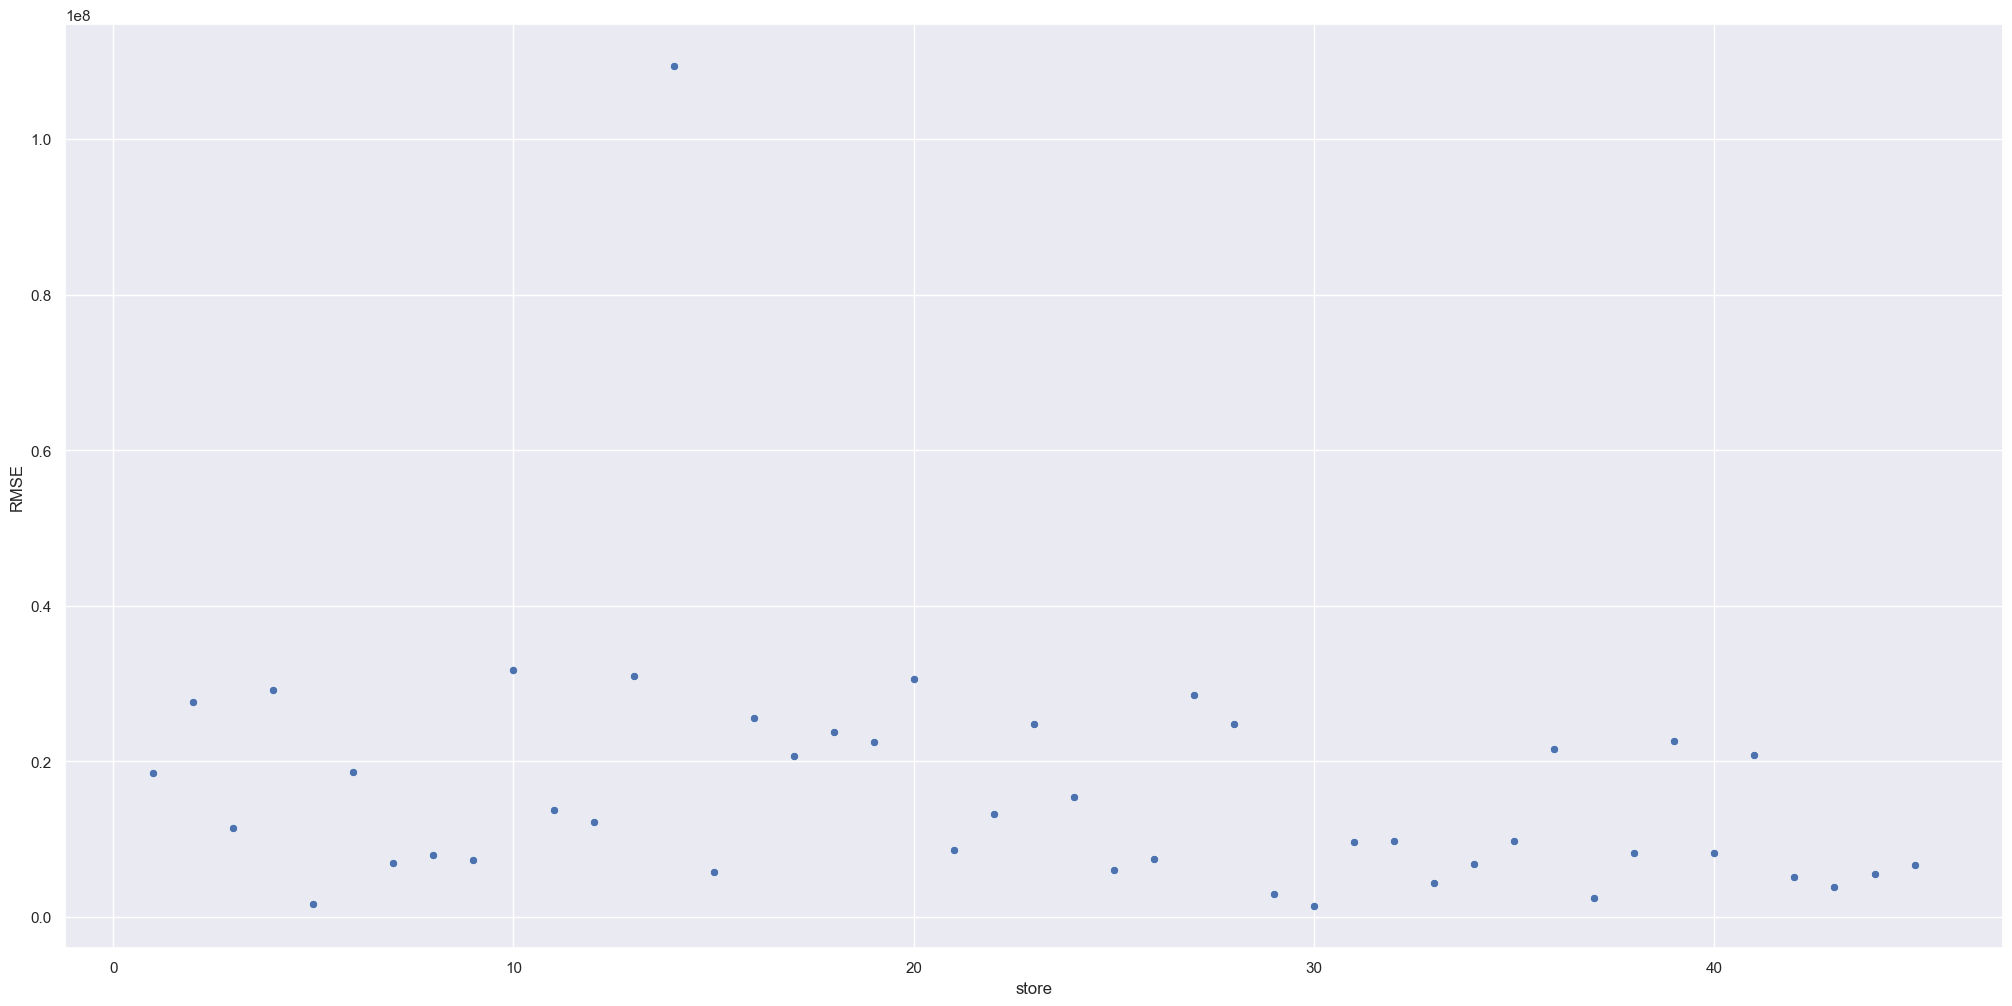

In [144]:
sns.scatterplot(x="store", y="RMSE", data=df92)


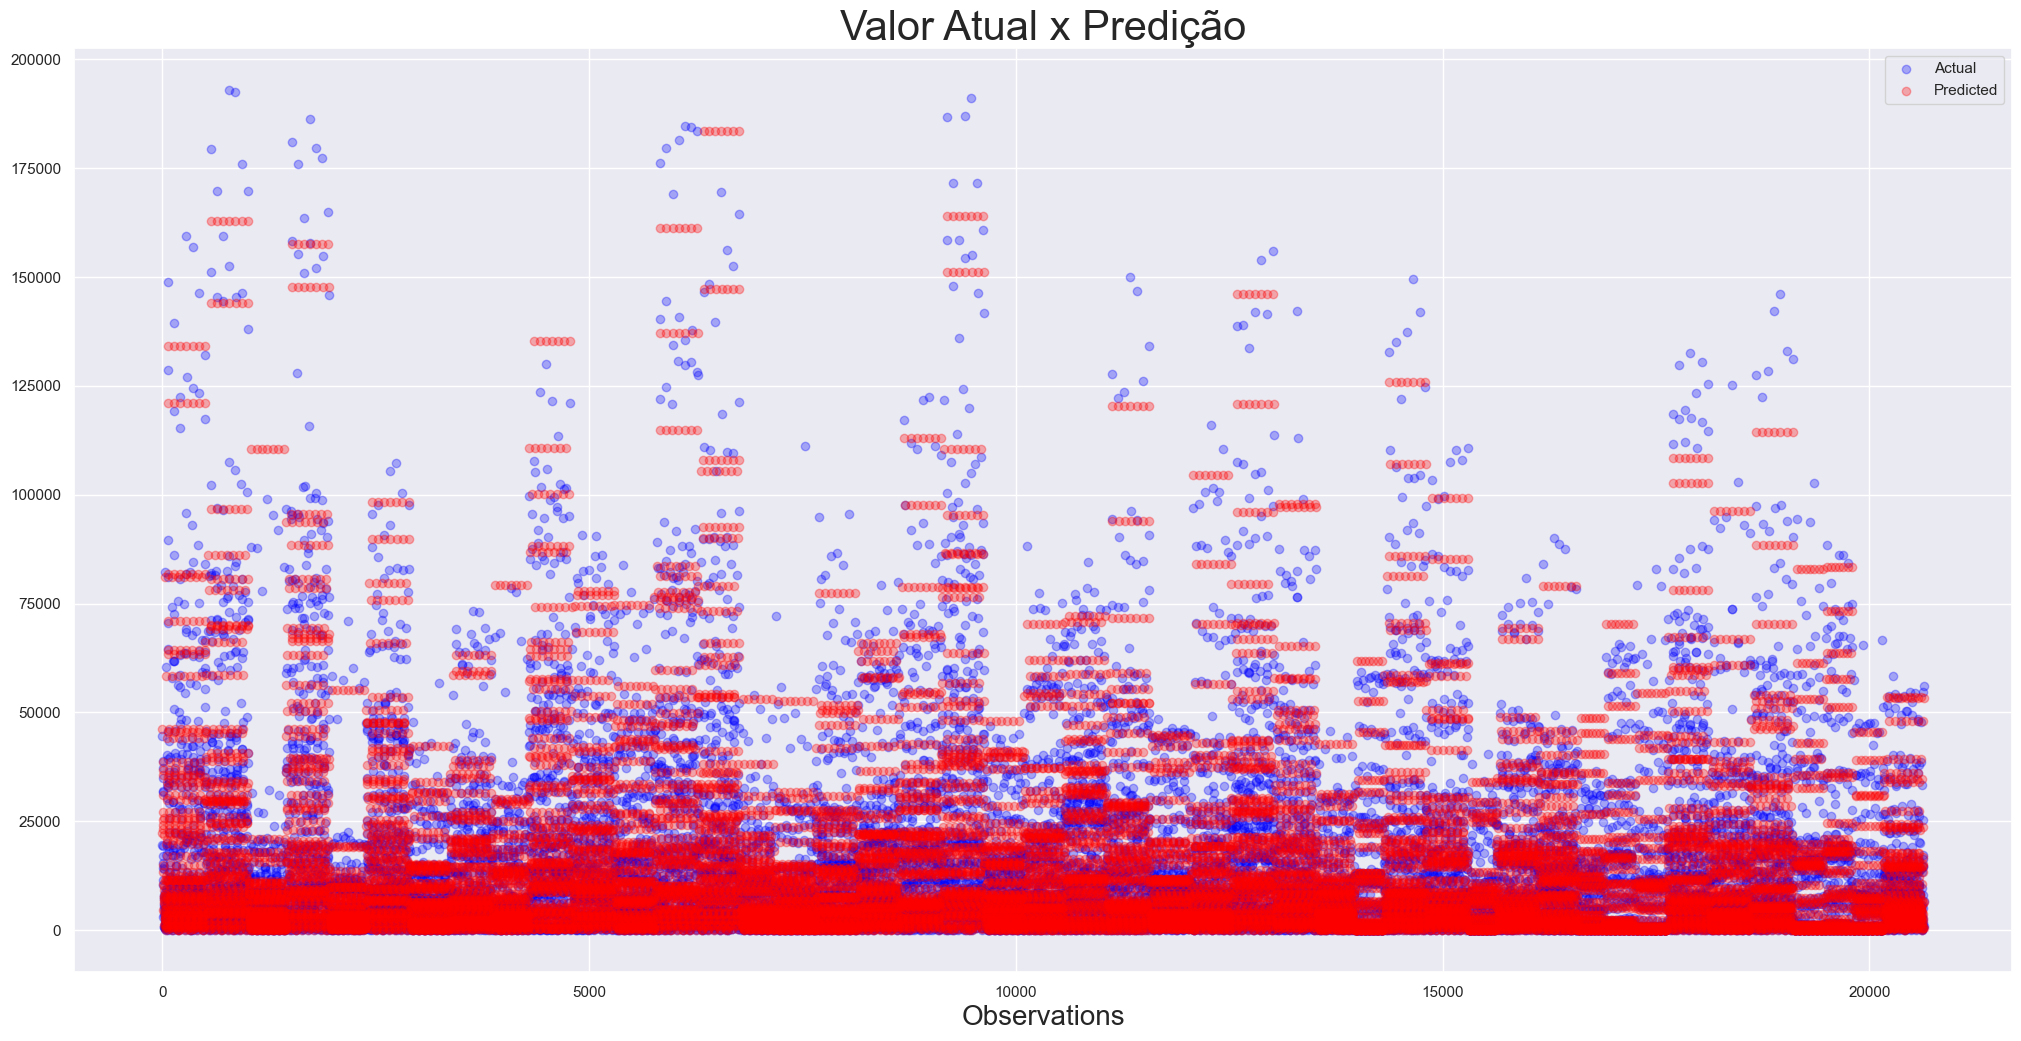

In [145]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_val.size), y=y_val, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, yhat_rf_model_tuned.size), y=yhat_rf_model_tuned, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Valor Atual x Predição', size=30)
plt.xlabel('Observations', size=20)
#plt.ylabel('mpg')

plt.legend()
plt.show();

# **9.2 Total Performance**

In [147]:
# resumo de melhor e pior cenário
# f no 2 é importante para mostrar o valor em reais
df93 = df92[["predicted", "pior_cenario", "melhor_cenario"]].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={"index":"Cenario", 0:"Valores"})
df93["Valores"] = df93["Valores"].map("RS{:,.2f}".format)
df93

,Cenario,Valores
0,predicted,"RS328,705,216.46"
1,pior_cenario,"RS-405,392,927.20"
2,melhor_cenario,"RS1,062,803,360.12"
